## Library

In [ ]:
!pip install --upgrade --force-reinstall nltk==3.8.1
import nltk
nltk.download('stopwords')
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: regex
    Found existing installation: regex 2025.11.3
    Uninstalling regex-2025.11.3:
      Successfully uninstalled regex-2025.11.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.3
    Uninstalling joblib-1.5.3:
      Successfully uninstall

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Imports & Settings
import os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import warnings
import re
warnings.filterwarnings("ignore")

# sklearn & helpers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from scipy.sparse import hstack

# Deep learning & transformers
try:
    import tensorflow as tf
    from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
    from tensorflow.keras.models import Model
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping
    HAVE_TF = True
except Exception:
    HAVE_TF = False

try:
    import torch
    from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
    HAVE_TRANSFORMERS = True
except Exception:
    HAVE_TRANSFORMERS = False

print("TF available:", HAVE_TF, "| Transformers available:", HAVE_TRANSFORMERS)

# Paths & global settings
DATA_PATH = "dataini.xlsx"
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Flags
DO_TRAIN_SVM = True
DO_TRAIN_BILSTM = True
DO_TRAIN_INDOBERT_EMBED = True
DO_FINE_TUNE_INDOBERT = True

# Hyperparams
SVM_ALPHA = 1e-4
BILSTM_EPOCHS = 20
BILSTM_BATCH = 32
MAX_WORDS = 30000
MAX_LEN = 100
EMBED_DIM = 128
BERT_MODEL = "indobenchmark/indobert-base-p1"
INDOBERT_FT_EPOCHS = 3
INDOBERT_FT_LR = 2e-5
LABEL_COLS = ["Layanan","Fitur","Kebermanfaatan","Bisnis","Non Aspek"]

print("Output folder:", OUTPUT_DIR)


TF available: True | Transformers available: True
Output folder: plots


## EDA

=== INFO DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19683 entries, 0 to 19682
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userName        19683 non-null  object
 1   score           19683 non-null  int64 
 2   content         19683 non-null  object
 3   Layanan         19683 non-null  int64 
 4   Fitur           19683 non-null  int64 
 5   Kebermanfaatan  19683 non-null  int64 
 6   Bisnis          19683 non-null  int64 
 7   Non Aspek       19683 non-null  int64 
 8   text_clean      19683 non-null  object
dtypes: int64(6), object(3)
memory usage: 1.4+ MB
None

=== DESKRIPSI DATA NUMERIK ===
              score       Layanan         Fitur  Kebermanfaatan        Bisnis  \
count  19683.000000  19683.000000  19683.000000    19683.000000  19683.000000   
mean       3.442971      0.042727      0.039120        0.072906      0.043388   
std        1.775889      0.530019      0.536725        0.523

userName  score                                            content  \
0   Kusyati Nisa      5  Mantaf skali mudah juga buat ikut pelatihan pr...   
1  Nurul Latifah      5                    keren buat beli kartu prakerjaa   
2    Lukman Hadi      1  Lapak saya dibekukan, sudah komplain tidak ada...   
3  Felisona Hulu      1  Benar2 mengecewakan.Respon sangat lama.pokok n...   
4     Don faizal      5  Ini adalah salah satu tempat terbaik untuk bel...   

   Layanan  Fitur  Kebermanfaatan  Bisnis  Non Aspek  \
0        0      0               1       0          0   
1        0      0               0       0          1   
2       -1      0               0       0          0   
3       -1      0               0       0          0   
4        1      0               0       0          0   

                                          text_clean  
0  mantaf skali mudah juga buat ikut pelatihan pr...  
1                    keren buat beli kartu prakerjaa  
2  lapak saya dibekukan, sudah komplain tidak ada...  
3  benar2 mengecewakan.respon sangat lama.pokok n...  
4  ini adalah salah satu tempat terbaik untuk bel...

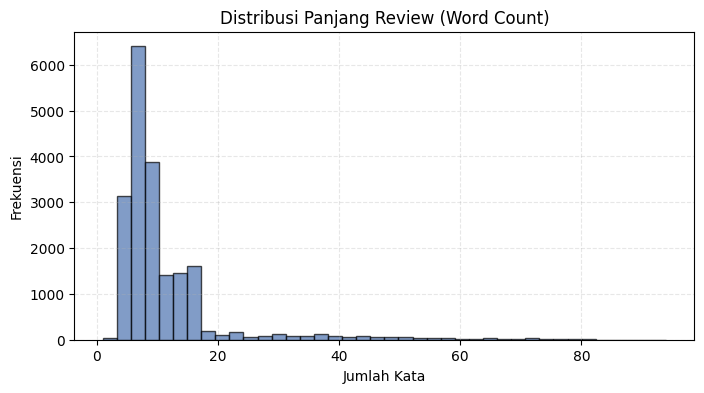

In [ ]:
# ==============================
# 1. BACA DATASET
# ==============================
df = pd.read_excel("dataset.xlsx")

# ==============================
# 2. PREPROCESSING TEKS
# ==============================
# Buat kolom text_clean dari content (lowercase, hapus spasi ekstra)
df["text_clean"] = df["content"].apply(lambda x: re.sub(r'\s+', ' ', str(x).lower().strip()))

# ==============================
# 3. INFO & DESKRIPSI DATA
# ==============================
print("=== INFO DATA ===")
print(df.info())

print("\n=== DESKRIPSI DATA NUMERIK ===")
print(df.describe())

print("\n=== SAMPLE 5 DATA ===")
display(df.head())

# ==============================
# 4. HISTOGRAM PANJANG TEKS
# ==============================
df["text_len"] = df["text_clean"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
plt.hist(df["text_len"], bins=40, color="#4C72B0", edgecolor="black", alpha=0.7)
plt.title("Distribusi Panjang Review (Word Count)")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


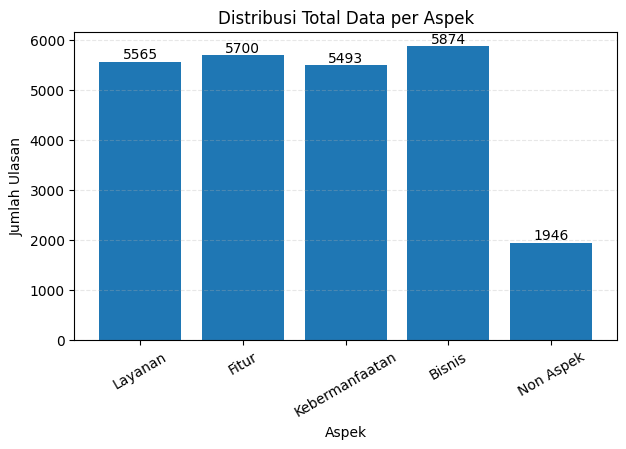

In [ ]:
# ===============================
# Distribusi Total Data per Aspek
# ===============================
import matplotlib.pyplot as plt

label_cols = ["Layanan", "Fitur", "Kebermanfaatan", "Bisnis", "Non Aspek"]

total_per_aspek = [
    (df[c] != 0).sum()
    for c in label_cols
]

plt.figure(figsize=(7,4))
bars = plt.bar(label_cols, total_per_aspek)

plt.title("Distribusi Total Data per Aspek")
plt.ylabel("Jumlah Ulasan")
plt.xlabel("Aspek")
plt.xticks(rotation=30)

# Tambahkan angka di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


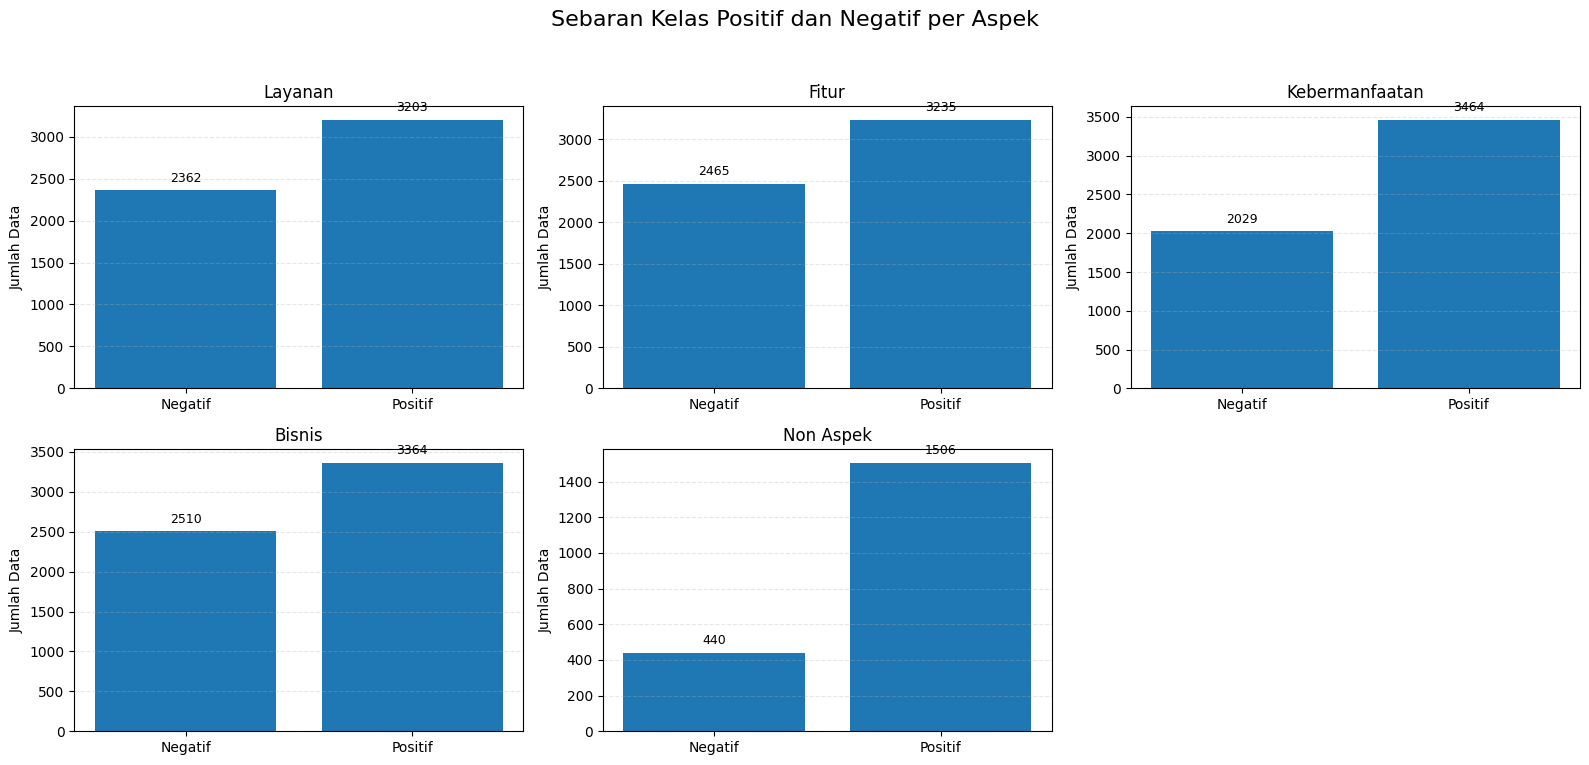

In [ ]:
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, aspek in enumerate(label_cols):
    ax = axes[i]

    df_as = df[df[aspek] != 0]

    pos = (df_as[aspek] == 1).sum()
    neg = (df_as[aspek] == -1).sum()

    counts = [neg, pos]
    labels = ["Negatif", "Positif"]

    bars = ax.bar(labels, counts)

    ax.set_title(aspek)
    ax.set_ylabel("Jumlah Data")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # tulis angka
    for bar in bars:
        y = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            y + max(counts)*0.02,
            f"{y}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# hapus subplot kosong
for j in range(len(label_cols), 6):
    fig.delaxes(axes[j])

fig.suptitle("Sebaran Kelas Positif dan Negatif per Aspek", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# ==============================
# Histogram Panjang Teks + Statistik
# ==============================
import numpy as np
import matplotlib.pyplot as plt

df["text_len"] = df["text_clean"].apply(lambda x: len(x.split()))

mean_len   = df["text_len"].mean()
median_len = df["text_len"].median()
max_len    = df["text_len"].max()
min_len    = df["text_len"].min()

plt.figure(figsize=(8,4))
plt.hist(df["text_len"], bins=40, edgecolor="black", alpha=0.7)

# Garis statistik
plt.axvline(mean_len, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_len:.1f}")
plt.axvline(median_len, color="green", linestyle="--", linewidth=2, label=f"Median = {median_len:.1f}")

plt.title("Distribusi Panjang Review (Jumlah Kata)")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Statistik numerik
print("Statistik Panjang Teks:")
print(f"Minimum : {min_len} kata")
print(f"Maksimum : {max_len} kata")
print(f"Rata-rata: {mean_len:.2f} kata")
print(f"Median  : {median_len} kata")


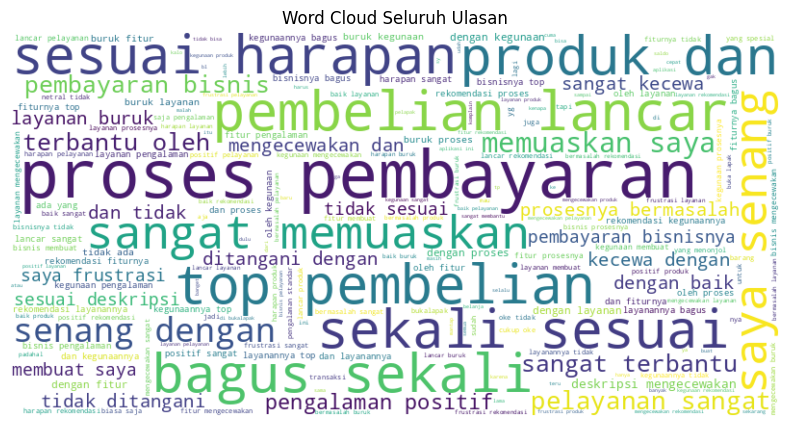

Statistik Kata:
Total kata       : 219308
Kata unik        : 12333

10 Kata Paling Sering Muncul:
sangat          : 8440
dengan          : 7246
dan             : 6467
saya            : 6350
tidak           : 5568
pembayaran      : 5020
proses          : 4962
sesuai          : 4962
/               : 4854
bagus           : 3186


In [ ]:
# ===============================
# Word Cloud + Statistik Kata
# ===============================
from wordcloud import WordCloud
from collections import Counter

text_all = " ".join(df["text_clean"].dropna())
words = text_all.split()

total_words = len(words)
unique_words = len(set(words))

# Top 10 kata
top_words = Counter(words).most_common(10)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(text_all)

plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Seluruh Ulasan")
plt.show()

print("Statistik Kata:")
print(f"Total kata       : {total_words}")
print(f"Kata unik        : {unique_words}")
print("\n10 Kata Paling Sering Muncul:")
for w, c in top_words:
    print(f"{w:15s} : {c}")


## Metrics

In [ ]:
def add_value_labels_multiline(ax, fmt="{:.3f}", fontsize=8, dy=0.005, dx=0.07):
    lines = ax.get_lines()

    for line_idx, line in enumerate(lines):
        xdata = line.get_xdata()
        ydata = line.get_ydata()

        # Label line 1 naik sedikit, line 2 naik lebih tinggi
        vert_offset = dy * (line_idx + 1)

        for point_idx, (x, y) in enumerate(zip(xdata, ydata)):

            # Zig-zag per kategori supaya tidak ada label tepat sejajar
            horizontal_offset = dx * ((point_idx % 2) * 2 - 1)

            ax.text(
                x + horizontal_offset,
                y + vert_offset,
                fmt.format(y),
                fontsize=fontsize,
                ha='center',
                va='bottom'
            )



In [ ]:
# ==============================
# PLOTTING REVISED
# ==============================

def plot_metric_scatter_line(metrics_no, metrics_with, prefix, aspek, modelname,
                             ymin=0.8, ymax=1.1):
    metrics = ["accuracy",
               "pos_precision","neg_precision",
               "pos_recall","neg_recall",
               "pos_f1","neg_f1"]

    x = np.arange(len(metrics))
    y1 = [metrics_no.get(m,0) for m in metrics]
    y2 = [metrics_with.get(m,0) for m in metrics] if metrics_with else None

    plt.figure(figsize=(11,5))
    plt.plot(x, y1, marker='o', label='Text only', linewidth=2)
    if y2:
        plt.plot(x, y2, marker='o', linestyle='--', label='Text + features', linewidth=2)

    plt.xticks(x, metrics, rotation=45)
    plt.ylim(ymin, ymax)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"{modelname} — {aspek}")
    plt.legend()
    ax = plt.gca()
    add_value_labels_multiline(ax)
    plt.show()


def plot_two_scenario(metrics_no, metrics_with, prefix, aspek, modelname):
    metrics = [
        "accuracy",
        "pos_precision","neg_precision",
        "pos_recall","neg_recall",
        "pos_f1","neg_f1"
    ]

    x = np.arange(len(metrics))

    no_vals   = [metrics_no.get(m,0) for m in metrics]
    with_vals = [metrics_with.get(m,0) for m in metrics]

    plt.figure(figsize=(14,5))

    # LEFT
    plt.subplot(1,2,1)
    plt.plot(x, no_vals, marker='o', linewidth=2)
    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.8,1.1)       # FIX SKALA
    plt.title(f"{modelname} - {aspek}\nText Only")
    ax = plt.gca()
    add_value_labels_multiline(ax)

    # RIGHT
    plt.subplot(1,2,2)
    plt.plot(x, with_vals, marker='o', linewidth=2, color='orange')
    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.8,1.1)       # FIX SKALA
    plt.title(f"{modelname} - {aspek}\nText + Features")
    ax = plt.gca()
    add_value_labels_multiline(ax)

    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
# Permutation importance general helper

from sklearn.metrics import accuracy_score

def permutation_importance_df(predict_fn, X_df, y_true, feat_list, n_repeats=5, random_state=42):
    """
    predict_fn: function(X_df) -> predictions (1-d array)
    X_df: pandas DataFrame with columns corresponding to feat_list (and possibly other cols)
    feat_list: list of column names to measure importance (if 'text_clean' included treat as text shuffle)
    returns: dict of importances (mean drop in accuracy), base_acc
    """
    rng = np.random.RandomState(random_state)
    base_preds = predict_fn(X_df.reset_index(drop=True))
    base_acc = accuracy_score(y_true, base_preds)
    importances = {}
    for feat in feat_list:
        drops = []
        for _ in range(n_repeats):
            X_shuffled = X_df.copy().reset_index(drop=True)
            if feat == 'text_clean':
                X_shuffled['text_clean'] = X_shuffled['text_clean'].sample(frac=1.0, random_state=rng.randint(0,1e9)).reset_index(drop=True)
            else:
                X_shuffled[feat] = X_shuffled[feat].sample(frac=1.0, random_state=rng.randint(0,1e9)).reset_index(drop=True)
            preds = predict_fn(X_shuffled)
            acc = accuracy_score(y_true, preds)
            drops.append(base_acc - acc)
        importances[feat] = float(np.mean(drops))
    importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
    return importances, float(base_acc)


In [ ]:
# ====================================================
# metrics_per_class
# ====================================================

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def metrics_per_class(y_true, y_pred):
    """
    Mengembalikan accuracy + precision/recall/F1 untuk kelas positif & negatif.
    """
    acc = accuracy_score(y_true, y_pred)

    # precision_recall_fscore_support output: (precision, recall, f1, support)
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[1,0], zero_division=0
    )

    # kelas positif = index 0 (karena urutan label=[1,0])
    # kelas negatif = index 1
    return {
        "accuracy": acc,
        "pos_precision": prec[0],
        "neg_precision": prec[1],
        "pos_recall": rec[0],
        "neg_recall": rec[1],
        "pos_f1": f1[0],
        "neg_f1": f1[1],
    }


In [ ]:
#plot_two_scenario
def plot_svm_combined(metrics_no, metrics_with, aspek):
    """
    Plot 2 skenario SVM (text-only vs text+feature) dalam 1 figure.
    """
    metrics = [
        "accuracy",
        "pos_precision","neg_precision",
        "pos_recall","neg_recall",
        "pos_f1","neg_f1"
    ]

    x = np.arange(len(metrics))

    y_no = [metrics_no.get(m, 0) for m in metrics]
    y_with = [metrics_with.get(m, 0) for m in metrics]

    plt.figure(figsize=(10,5))

    plt.plot(x, y_no, marker="o", linewidth=2, label="Text Only")
    plt.plot(x, y_with, marker="s", linewidth=2, label="Text + Feature")

    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.8, 1.1) #skala
    plt.title(f"SVM Comparison (Text vs Feature) — {aspek}")
    plt.ylabel("Score")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    add_value_labels_multiline(ax)
    plt.show()


#plot_svm_coef_importance()
def plot_svm_coef_importance(tfidf, coef, aspek, top_k=20):
    """
    Menampilkan 20 fitur TF-IDF paling penting untuk model SVM.
    Hanya untuk text-only (coef_ dari SGDClassifier).
    """

    # coef shape = (1, n_features)
    weights = coef.ravel()

    # Ambil semua nama fitur dari TF-IDF
    feature_names = np.array(tfidf.get_feature_names_out())

    # Ambil top-k positif & top-k negatif
    top_pos_idx = np.argsort(weights)[-top_k:]
    top_neg_idx = np.argsort(weights)[:top_k]

    top_pos = feature_names[top_pos_idx]
    top_neg = feature_names[top_neg_idx]
    top_pos_w = weights[top_pos_idx]
    top_neg_w = weights[top_neg_idx]

    # Plot untuk positif
    plt.figure(figsize=(10,5))
    plt.barh(top_pos, top_pos_w, color='blue')
    plt.title(f"SVM Positive Coefficients — {aspek}")
    plt.xlabel("Coefficient Weight")
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # Plot untuk negatif
    plt.figure(figsize=(10,5))
    plt.barh(top_neg, top_neg_w, color='blue')
    plt.title(f"SVM Negative Coefficients — {aspek}")
    plt.xlabel("Coefficient Weight")
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()


## TF-IDF SVM


SVM - aspek: Layanan
  text-only acc: 0.9901168014375562
  text+feat acc: 0.9883198562443846


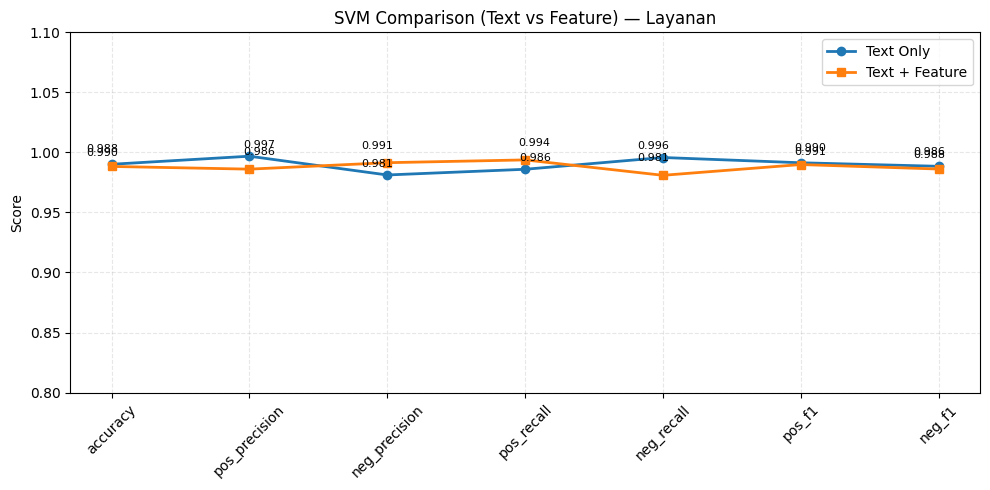

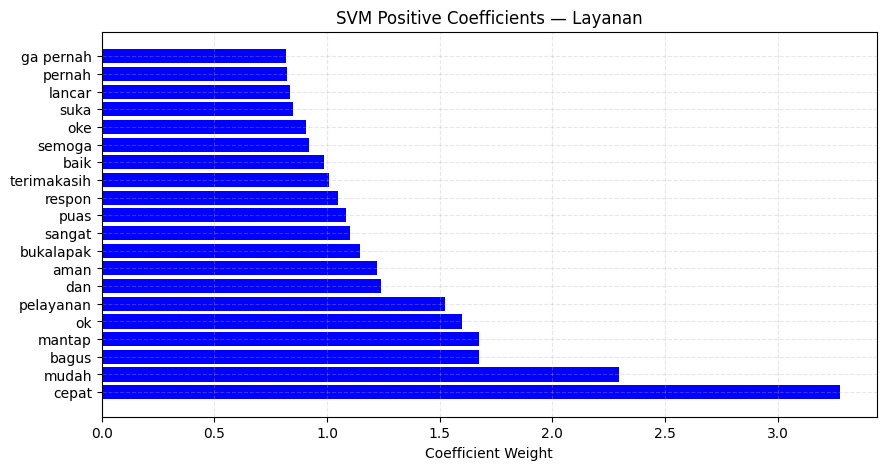

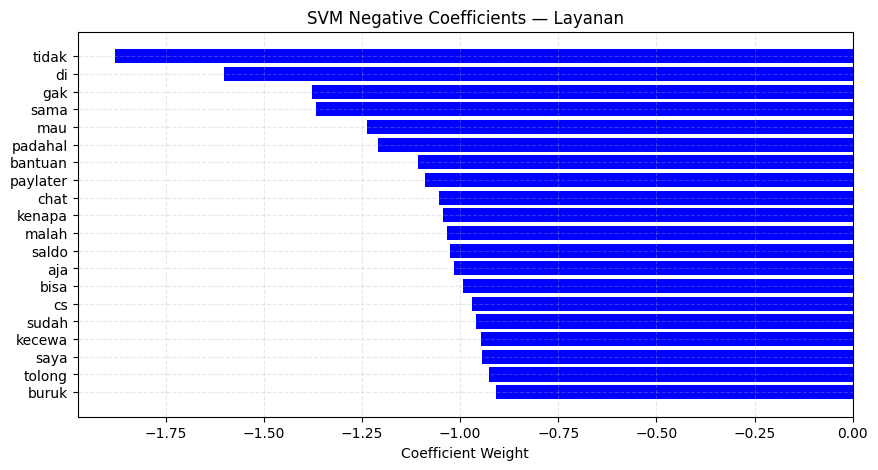

  SVM perm importance (top5): [('score', 0.4294699011680144), ('text_clean', 0.059973045822102417)]

SVM - aspek: Fitur
  text-only acc: 0.9850877192982456
  text+feat acc: 0.987719298245614


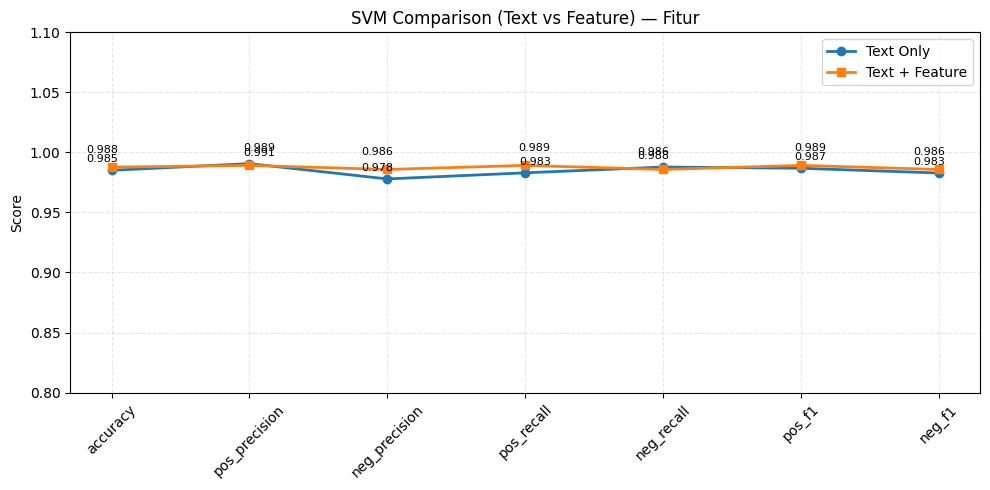

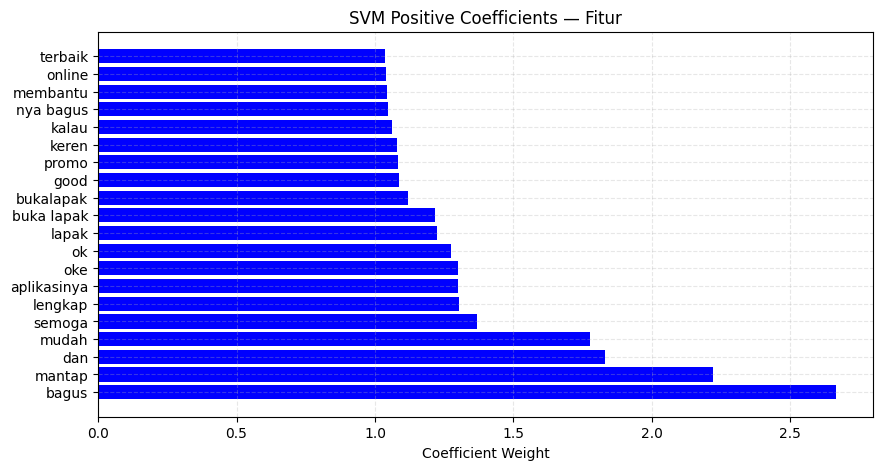

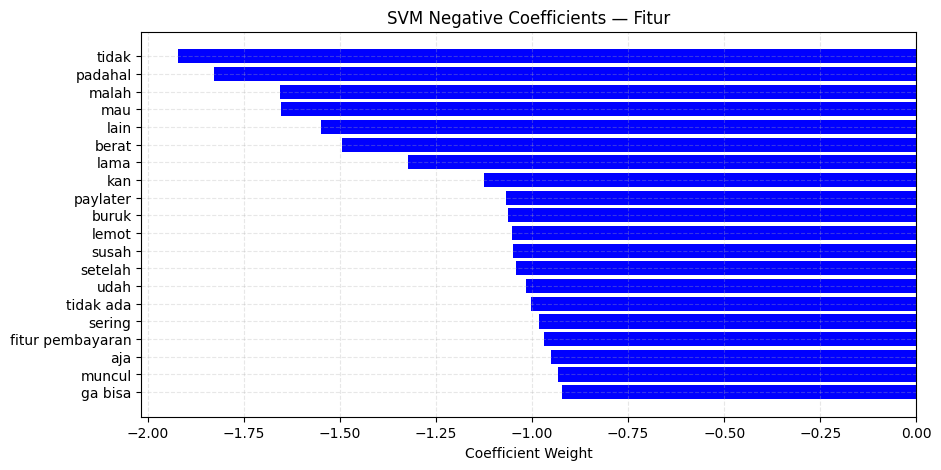

  SVM perm importance (top5): [('text_clean', 0.4592105263157894), ('score', 0.019517543859649072)]

SVM - aspek: Kebermanfaatan
  text-only acc: 0.9963603275705186
  text+feat acc: 0.997270245677889


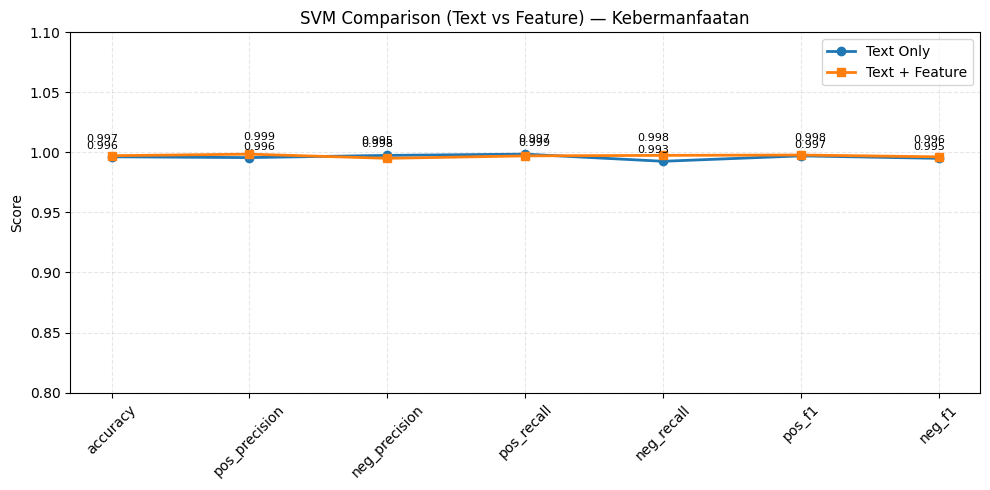

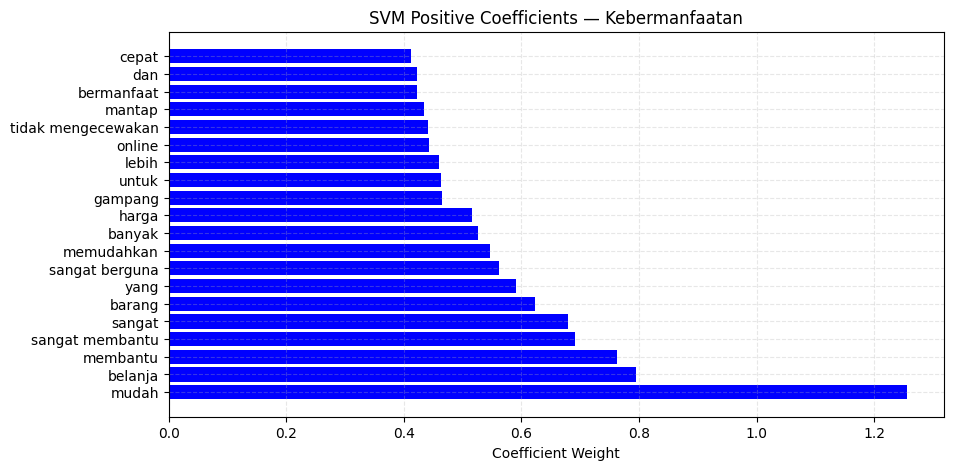

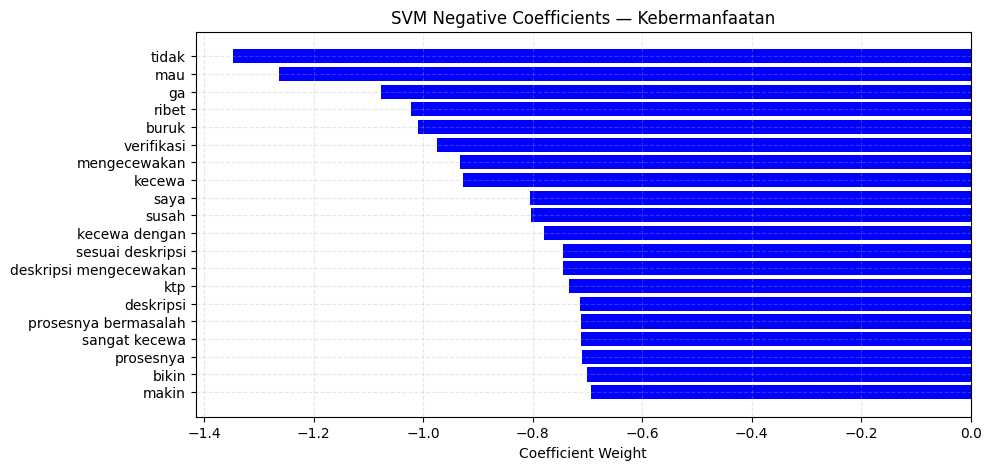

  SVM perm importance (top5): [('score', 0.4563239308462239), ('text_clean', 0.009099181073703388)]

SVM - aspek: Bisnis
  text-only acc: 0.9931914893617021
  text+feat acc: 0.9906382978723405


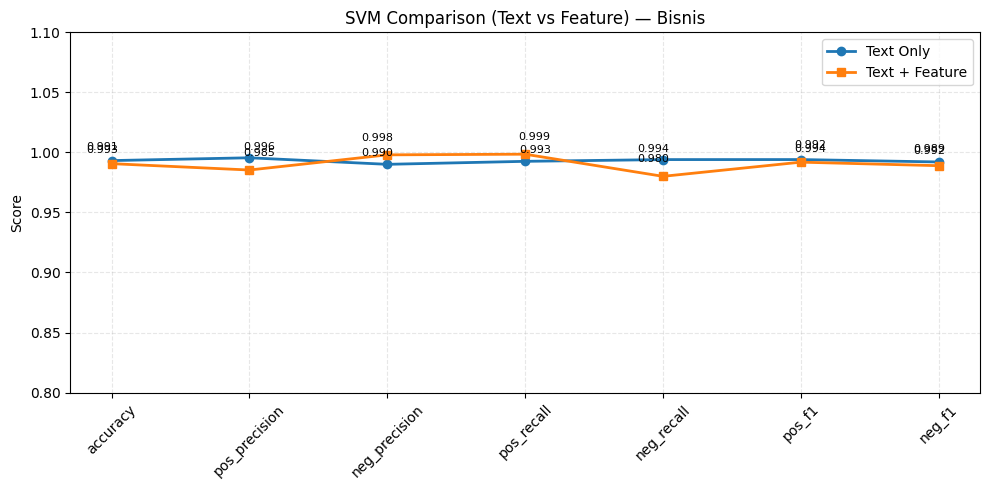

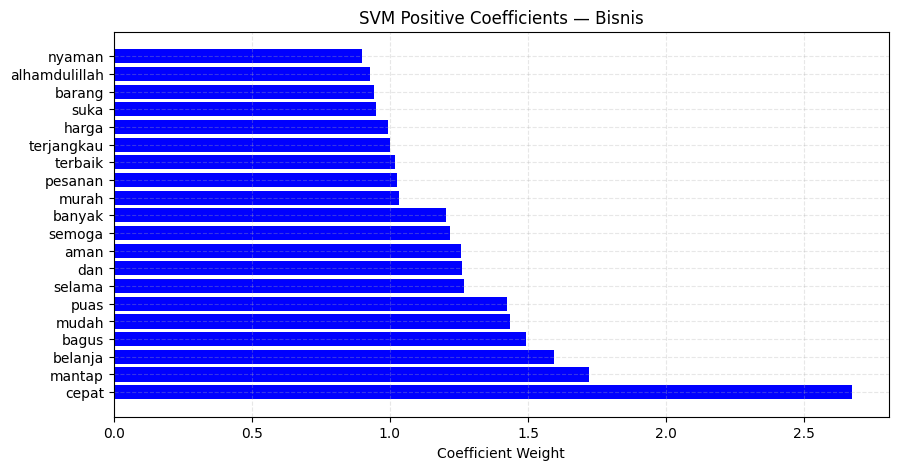

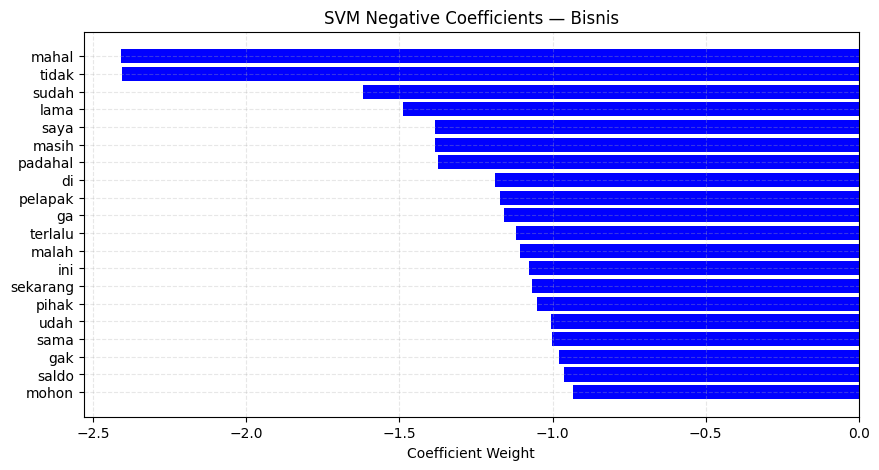

  SVM perm importance (top5): [('score', 0.4172340425531916), ('text_clean', 0.06617021276595747)]

SVM - aspek: Non Aspek
  text-only acc: 0.9205128205128205
  text+feat acc: 0.9435897435897436


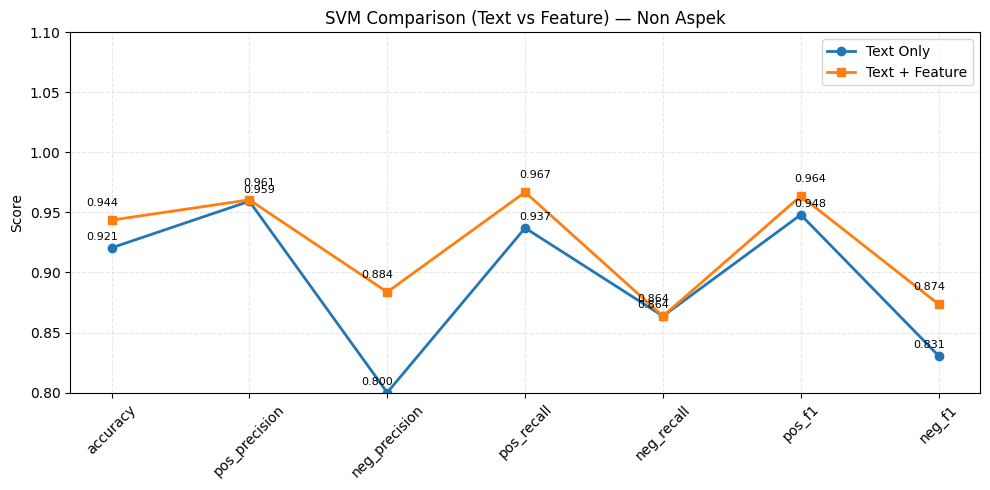

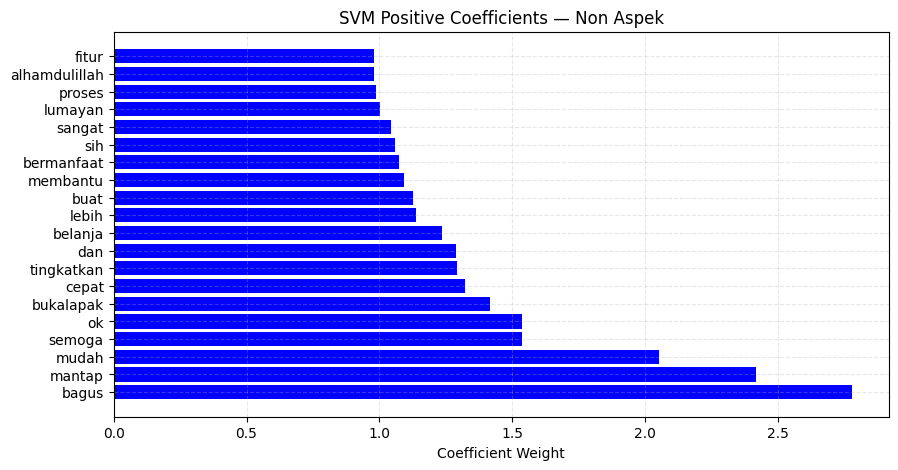

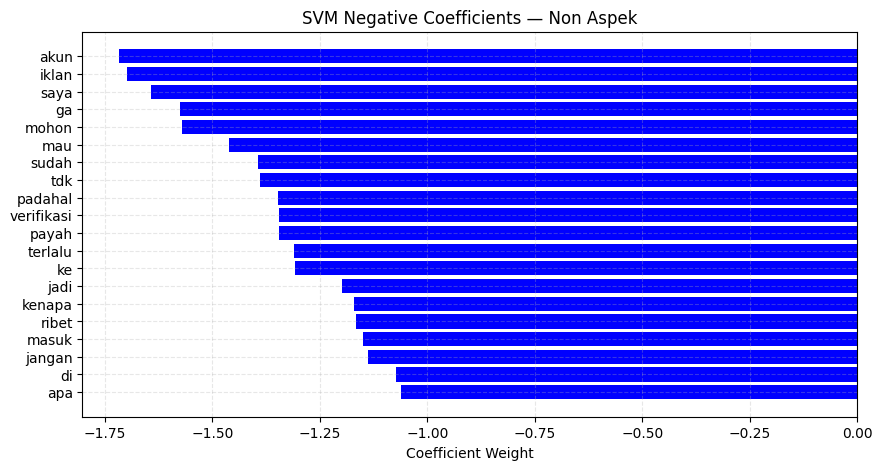

  SVM perm importance (top5): [('text_clean', 0.28846153846153844), ('score', 0.051282051282051294)]

Saved results_summary_svm.csv


In [ ]:
# ================================================================
# =============  ADD FUNCTIONS FOR EXTRA FEATURES  ==========
# ================================================================


feature_cols = ["score"]

# fungsi proses fitur
def preprocess_additional_features(df, feature_cols):
    """mengambil kolom fitur tambahan dalam bentuk DataFrame / array"""
    if not feature_cols:
        return np.zeros((len(df),0))
    return df[feature_cols].astype(float)

# scaler global
scaler = StandardScaler()


# ================================================================
# =============         SVM: TF-IDF + SVM       ===================
# ================================================================

GLOBAL_RESULTS = {"SVM": {}, "BiLSTM": {}, "IndoBERT": {}}
results_summary = []

def order_metrics(mdict):
    order = [
        "accuracy",
        "pos_precision", "neg_precision",
        "pos_recall", "neg_recall",
        "pos_f1", "neg_f1"
    ]
    return {k: mdict[k] for k in order if k in mdict}


# --------------------------- MAIN SVM LOOP -----------------------
if DO_TRAIN_SVM:

    for aspek in LABEL_COLS:
        print("\n" + "="*40)
        print("SVM - aspek:", aspek)

        df_as = df[df[aspek] != 0].copy()
        if len(df_as) < 30:
            print("  skip (too few):", aspek)
            continue

        # Split data
        train, test = train_test_split(
            df_as, test_size=0.20, stratify=df_as[aspek], random_state=42
        )
        y_train = (train[aspek] == 1).astype(int).values
        y_test  = (test[aspek] == 1).astype(int).values

        # TF-IDF
        tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
        Xtr_text = tfidf.fit_transform(train['text_clean'])
        Xte_text = tfidf.transform(test['text_clean'])


        # ---------------- Additional Features --------------------
        if feature_cols:
            Xf_tr = preprocess_additional_features(train, feature_cols)
            Xf_te = preprocess_additional_features(test, feature_cols)

            # FIT SCALER
            scaler.fit(Xf_tr)

            Xf_tr_s = scaler.transform(Xf_tr)
            Xf_te_s = scaler.transform(Xf_te)
        else:
            Xf_tr_s = Xf_te_s = None


        # ================= TEXT ONLY =============================
        clf = SGDClassifier(loss="hinge", alpha=SVM_ALPHA, random_state=42)
        clf.fit(Xtr_text, y_train)
        preds_no = clf.predict(Xte_text)
        metrics_no = metrics_per_class(y_test, preds_no)
        print("  text-only acc:", metrics_no["accuracy"])


        # ================= TEXT + FEATURES ========================
        if Xf_tr_s is not None:
            Xtr_comb = hstack([Xtr_text, Xf_tr_s])
            Xte_comb = hstack([Xte_text, Xf_te_s])

            clf2 = SGDClassifier(loss="hinge", alpha=SVM_ALPHA, random_state=42)
            clf2.fit(Xtr_comb, y_train)

            preds_with = clf2.predict(Xte_comb)
            metrics_with = metrics_per_class(y_test, preds_with)
            print("  text+feat acc:", metrics_with["accuracy"])
        else:
            clf2 = None
            metrics_with = metrics_no


        # ================= SAVE RESULTS ===========================
        GLOBAL_RESULTS["SVM"][aspek] = {
            "no_feat": metrics_no,
            "with_feat": metrics_with
        }

        results_summary.append({
            "aspek": aspek, "method": "TFIDF_SVM",
            **{f"no_{k}": metrics_no[k] for k in metrics_no},
            **{f"with_{k}": metrics_with[k] for k in metrics_with}
        })

        # ================= PLOTTING ===============================
        plot_svm_combined(metrics_no, metrics_with, aspek)


        # ================= COEF IMPORTANCE =========================
        if hasattr(clf, "coef_"):
            plot_svm_coef_importance(tfidf, clf.coef_, aspek, top_k=20)


        # ================= PERMUTATION IMPORTANCE ==================
        if clf2 is not None:
            def pred_svm_df(Xdf):
                Xtxt = tfidf.transform(Xdf["text_clean"])
                Xf_ = preprocess_additional_features(Xdf, feature_cols)
                Xf_s_ = scaler.transform(Xf_)
                Xc = hstack([Xtxt, Xf_s_])
                return clf2.predict(Xc)

            feat_list = ["text_clean"] + feature_cols
            perm_imp, base = permutation_importance_df(
                lambda X: pred_svm_df(X),
                test.reset_index(drop=True)[["text_clean"] + feature_cols],
                y_test,
                feat_list,
                n_repeats=4
            )
            print("  SVM perm importance (top5):", list(perm_imp.items())[:5])


        # ================= SAVE MODEL =============================
        joblib.dump(
            {"clf": clf, "tfidf": tfidf},
            os.path.join(OUTPUT_DIR, f"svm_{aspek}_textonly.joblib")
        )

        if clf2 is not None:
            joblib.dump(
                {"clf_withfeat": clf2},
                os.path.join(OUTPUT_DIR, f"svm_{aspek}_withfeat.joblib")
            )


    # save summary csv
    pd.DataFrame(results_summary).to_csv(
        os.path.join(OUTPUT_DIR, "results_summary_svm.csv"), index=False
    )
    print("\nSaved results_summary_svm.csv")

else:
    print("Skipping SVM…")


In [ ]:
def plot_svm_grid(global_results):
    metrics = [
        "accuracy",
        "pos_precision","neg_precision",
        "pos_recall","neg_recall",
        "pos_f1","neg_f1"
    ]

    aspek_list = list(global_results.keys())

    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, aspek in enumerate(aspek_list):
        ax = axes[i]

        m_no   = global_results[aspek]["no_feat"]
        m_with = global_results[aspek]["with_feat"]

        y_no   = [m_no.get(m, 0) for m in metrics]
        y_with = [m_with.get(m, 0) for m in metrics]
        x = np.arange(len(metrics))

        # ===== Plot garis =====
        ax.plot(x, y_no, marker='o', linewidth=2, label="Text Only")
        ax.plot(x, y_with, marker='s', linestyle='--', linewidth=2, label="Text + Feature")

        # ===== Penulisan nilai (DINAMIS & BENAR) =====
        for xi, v_no, v_with in zip(x, y_no, y_with):

            if v_no >= v_with:
                # text-only lebih tinggi
                ax.text(xi, v_no + 0.015, f"{v_no:.3f}",
                        ha='center', va='bottom', fontsize=8)
                ax.text(xi, v_with - 0.020, f"{v_with:.3f}",
                        ha='center', va='top', fontsize=8)
            else:
                # text+feature lebih tinggi
                ax.text(xi, v_with + 0.015, f"{v_with:.3f}",
                        ha='center', va='bottom', fontsize=8)
                ax.text(xi, v_no - 0.020, f"{v_no:.3f}",
                        ha='center', va='top', fontsize=8)

        # ===== Axis settings =====
        ax.set_title(aspek, fontsize=11)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, fontsize=9)
        ax.set_ylim(0.7, 1.05)
        ax.grid(True, linestyle="--", alpha=0.3)

    # ===== Hapus subplot kosong =====
    for j in range(len(aspek_list), 6):
        fig.delaxes(axes[j])

    # ===== Legend global =====
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="lower center",
        ncol=2,
        fontsize=11,
        frameon=False
    )

    fig.suptitle(
        "Perbandingan Performa SVM per Aspek (Scatter + Line)",
        fontsize=16
    )

    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()


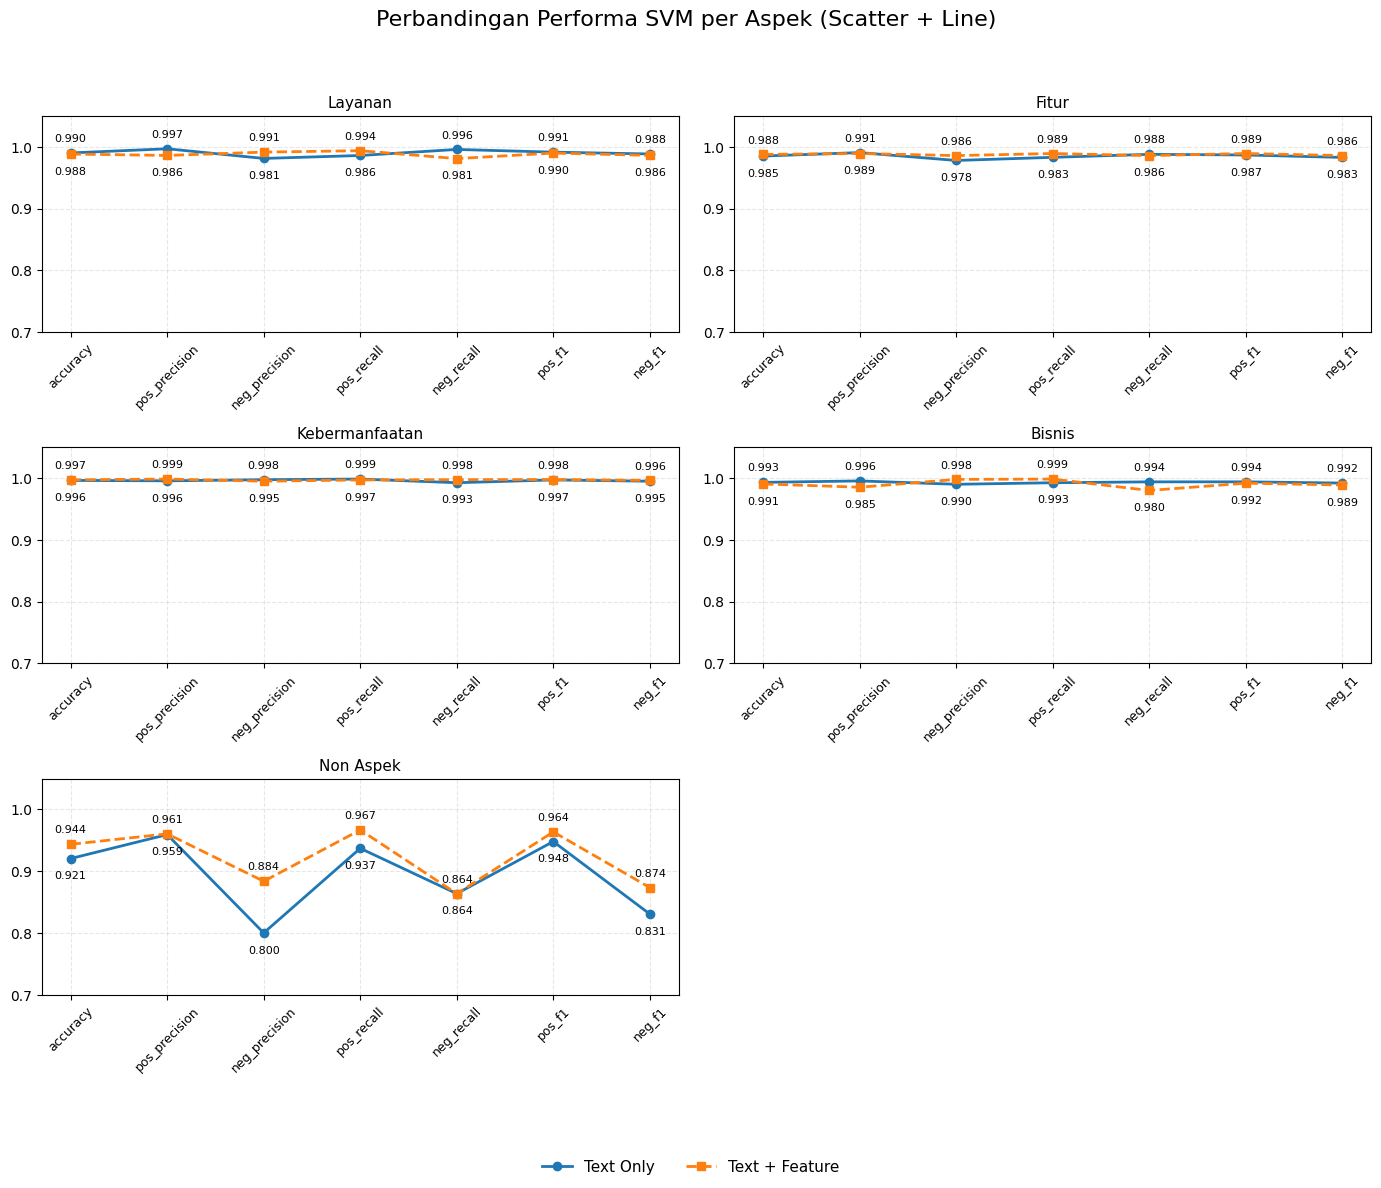

In [ ]:
plot_svm_grid(GLOBAL_RESULTS["SVM"])


## BiLSTM


=== BiLSTM Aspek: Layanan ===
Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.7921 - loss: 0.3669 - val_accuracy: 0.9910 - val_loss: 0.0365
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9929 - loss: 0.0250 - val_accuracy: 0.9933 - val_loss: 0.0249
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9933 - val_loss: 0.0233
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9888 - val_loss: 0.0312
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 4.6684e-04 - val_accuracy: 0.9910 - val_loss: 0.0303
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 1.0000 - loss: 1.6635e-04 - val_accuracy: 0.9910 - val_loss: 0.0324
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 1.0000 - loss: 1.1941e-04 - val_accuracy: 0.9933 - val_loss: 0.0335
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step 

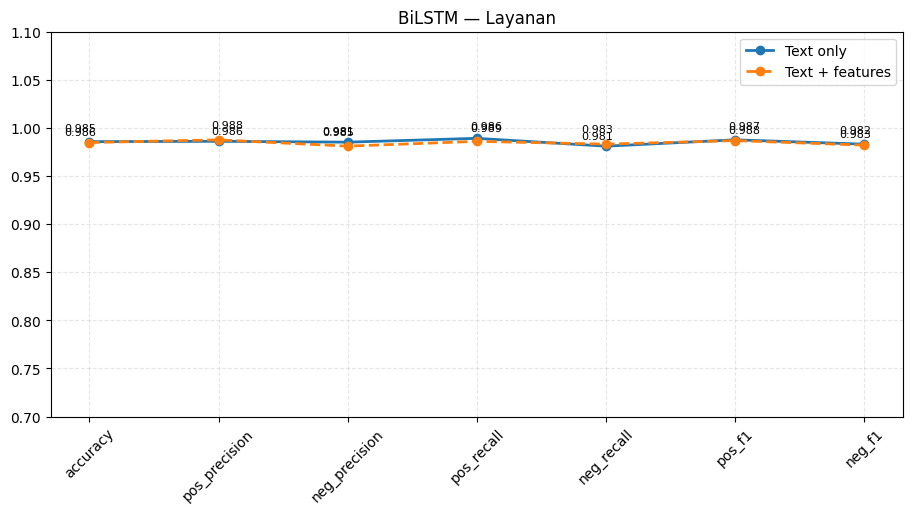

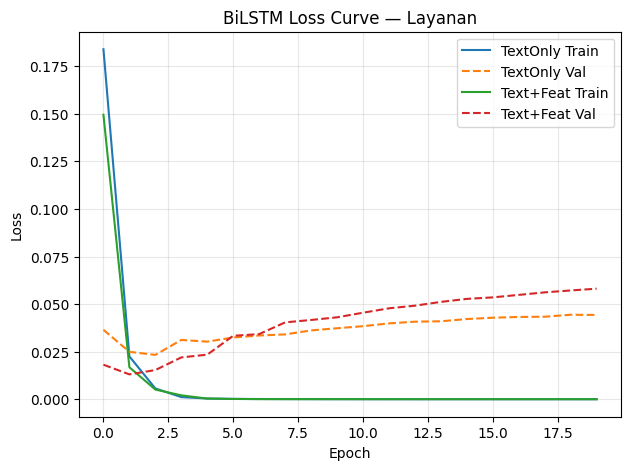


--- BiLSTM PERMUTATION IMPORTANCE — TOP TOKENS ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━

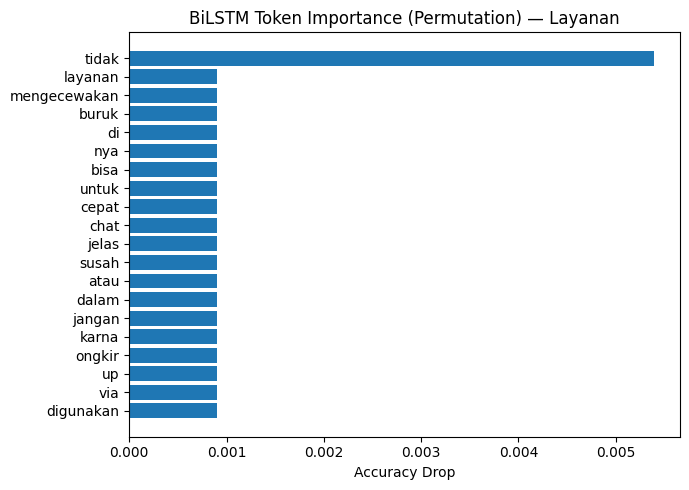


=== BiLSTM Aspek: Fitur ===
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7689 - loss: 0.3860 - val_accuracy: 0.9693 - val_loss: 0.0752
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9760 - loss: 0.0622 - val_accuracy: 0.9693 - val_loss: 0.0804
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9930 - loss: 0.0207 - val_accuracy: 0.9693 - val_loss: 0.0996
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9583 - val_loss: 0.1374
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9627 - val_loss: 0.1899
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9649 - val_loss: 0.1599
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9649 - val_loss: 0.1848
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0

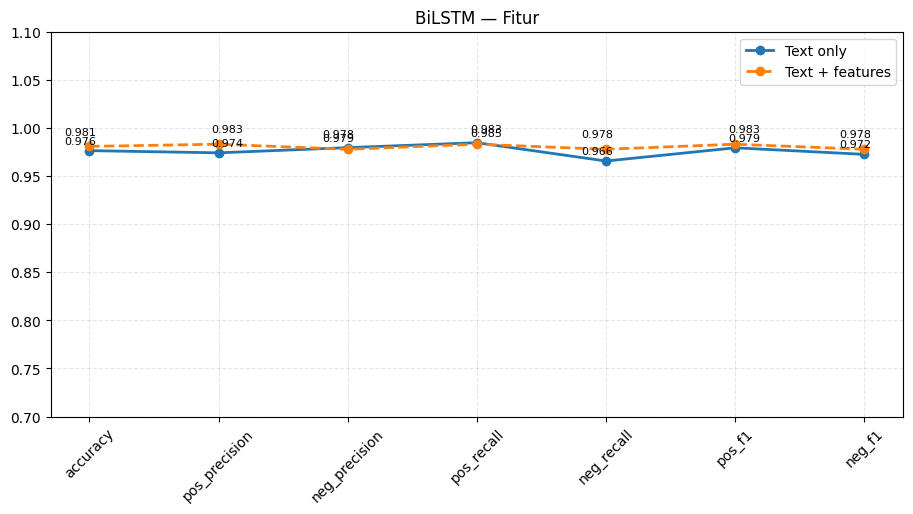

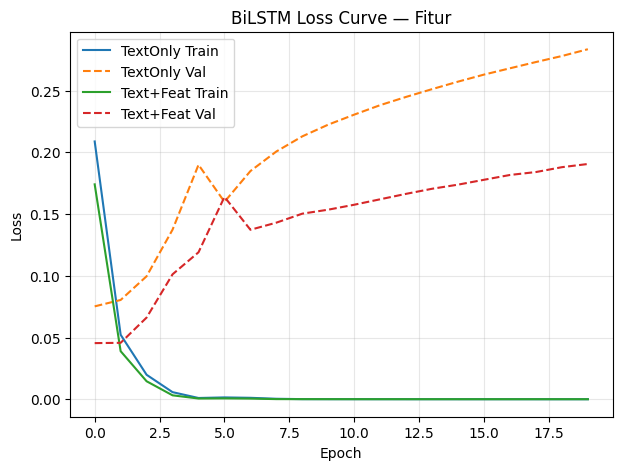


--- BiLSTM PERMUTATION IMPORTANCE — TOP TOKENS ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━

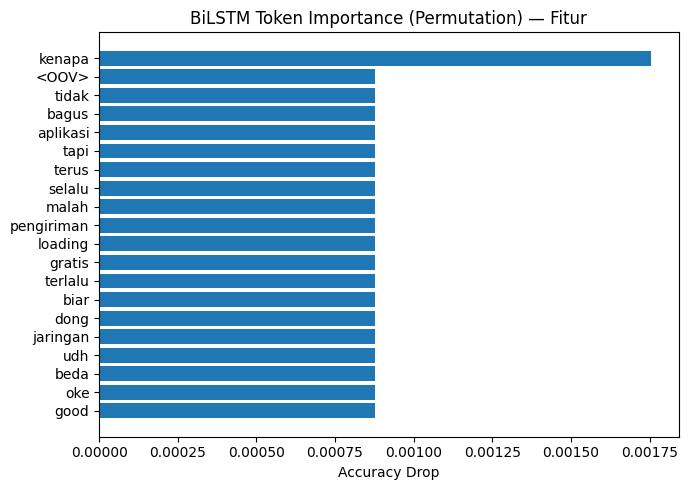


=== BiLSTM Aspek: Kebermanfaatan ===
Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8278 - loss: 0.3514 - val_accuracy: 0.9818 - val_loss: 0.1056
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9952 - loss: 0.0106 - val_accuracy: 0.9818 - val_loss: 0.0498
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9980 - loss: 0.0045 - val_accuracy: 0.9841 - val_loss: 0.0736
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 4.2875e-04 - val_accuracy: 0.9864 - val_loss: 0.0791
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.8864e-04 - val_accuracy: 0.9864 - val_loss: 0.0864
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 7.0942e-05 - val_accuracy: 0.9864 - val_loss: 0.0900
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 4.3977e-05 - val_accuracy: 0.9864 - val_loss: 0.0952
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 

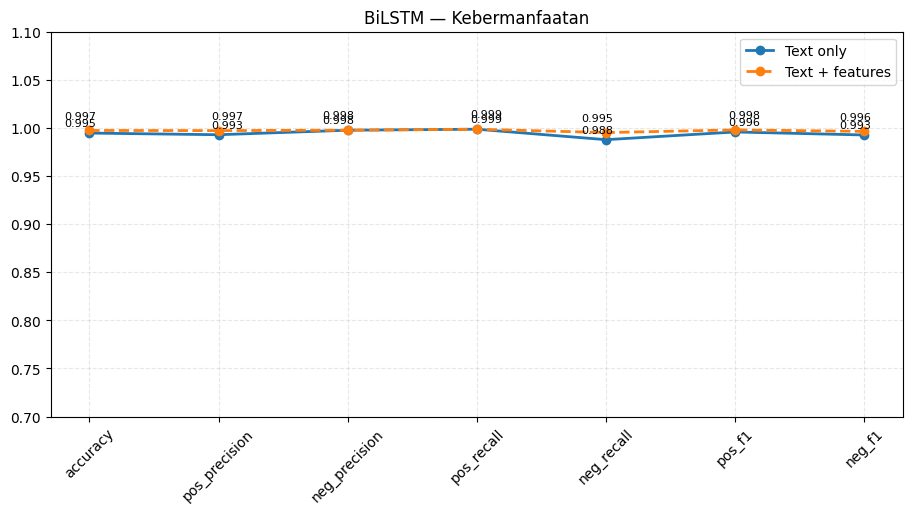

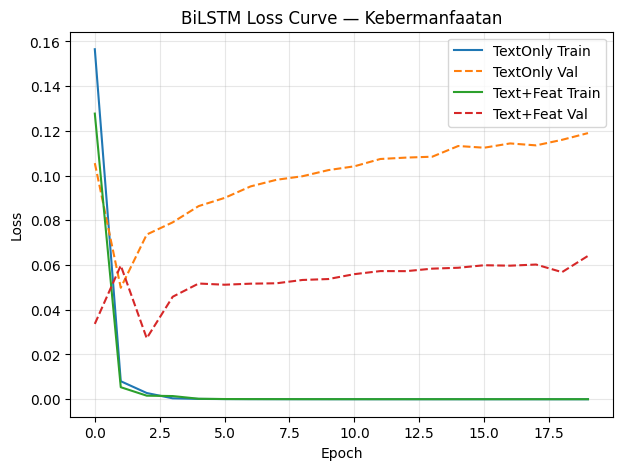


--- BiLSTM PERMUTATION IMPORTANCE — TOP TOKENS ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━

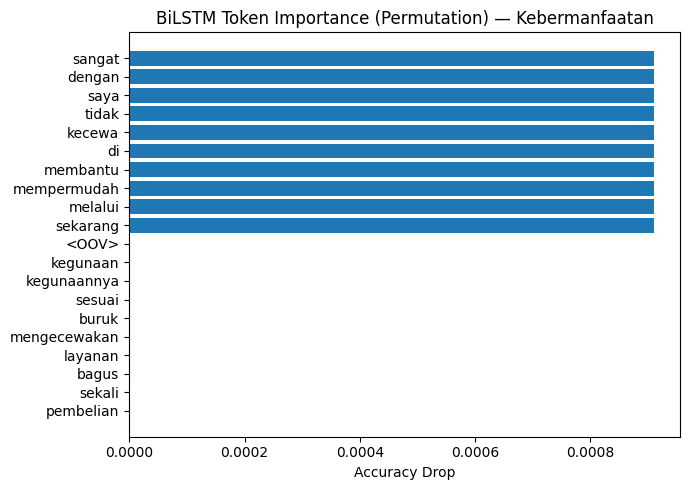


=== BiLSTM Aspek: Bisnis ===
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8038 - loss: 0.3697 - val_accuracy: 0.9766 - val_loss: 0.0578
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9906 - loss: 0.0351 - val_accuracy: 0.9787 - val_loss: 0.0600
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9971 - loss: 0.0102 - val_accuracy: 0.9745 - val_loss: 0.0771
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9981 - loss: 0.0042 - val_accuracy: 0.9766 - val_loss: 0.0834
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9681 - val_loss: 0.0891
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9991 - loss: 0.0042 - val_accuracy: 0.9702 - val_loss: 0.1123
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.9702 - val_loss: 0.1028
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.

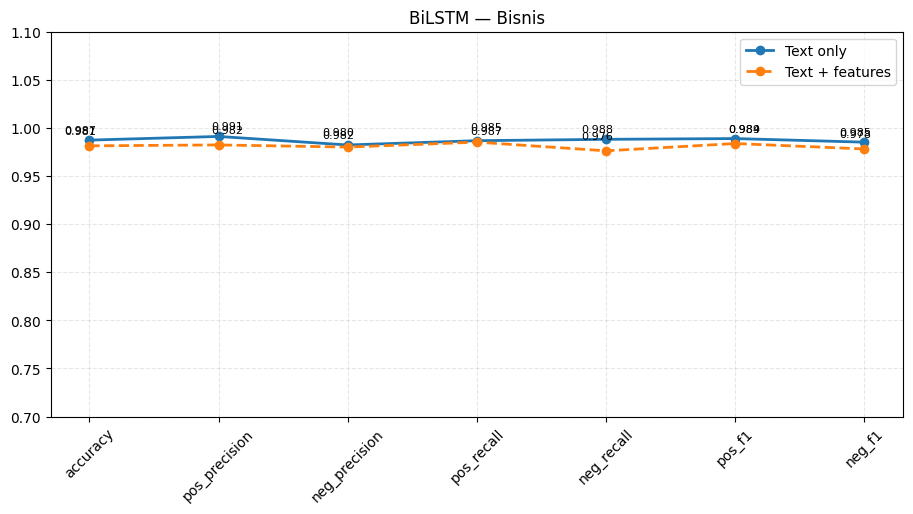

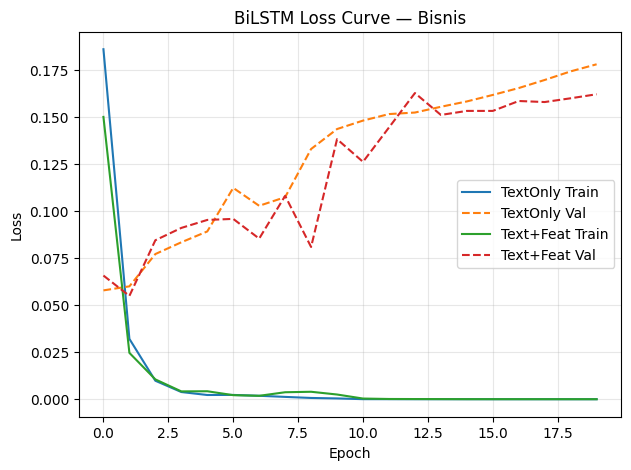


--- BiLSTM PERMUTATION IMPORTANCE — TOP TOKENS ---
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
37/37 ━━━━━━

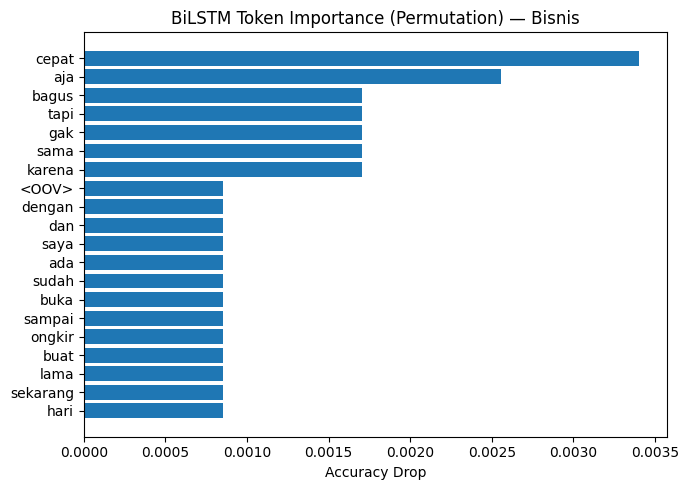


=== BiLSTM Aspek: Non Aspek ===
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7173 - loss: 0.5298 - val_accuracy: 0.8462 - val_loss: 0.3095
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8747 - loss: 0.2566 - val_accuracy: 0.8718 - val_loss: 0.2537
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9282 - loss: 0.1738 - val_accuracy: 0.8654 - val_loss: 0.2789
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9686 - loss: 0.0698 - val_accuracy: 0.8846 - val_loss: 0.3147
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.8974 - val_loss: 0.2888
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8910 - val_loss: 0.3518
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8974 - val_loss: 0.3845
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 

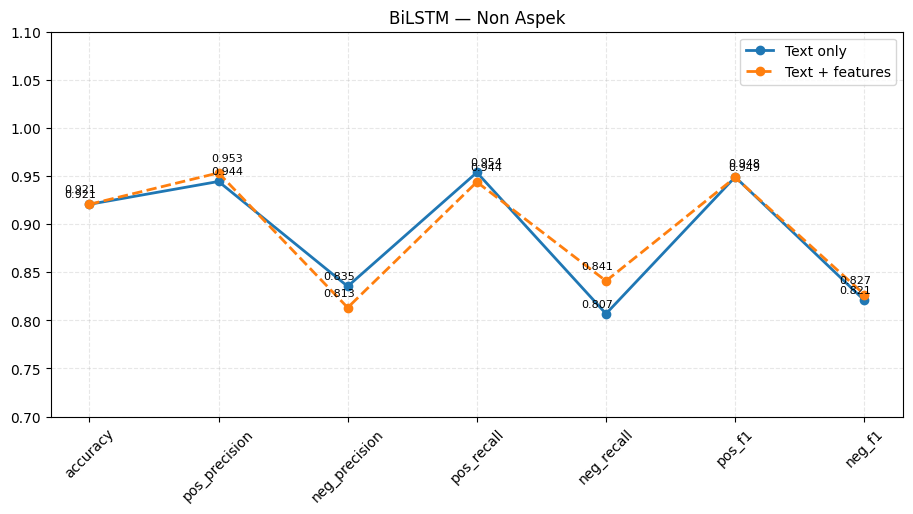

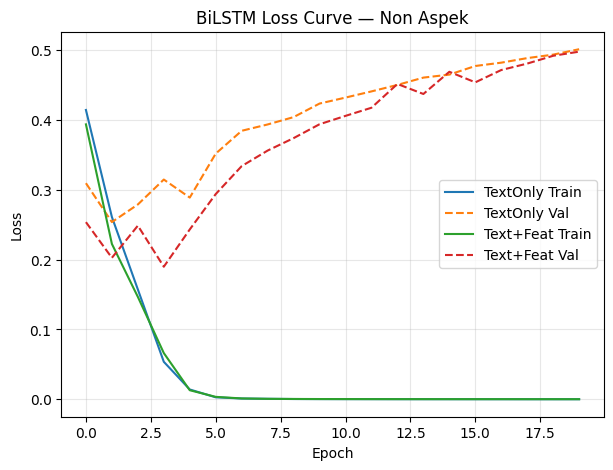


--- BiLSTM PERMUTATION IMPORTANCE — TOP TOKENS ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━

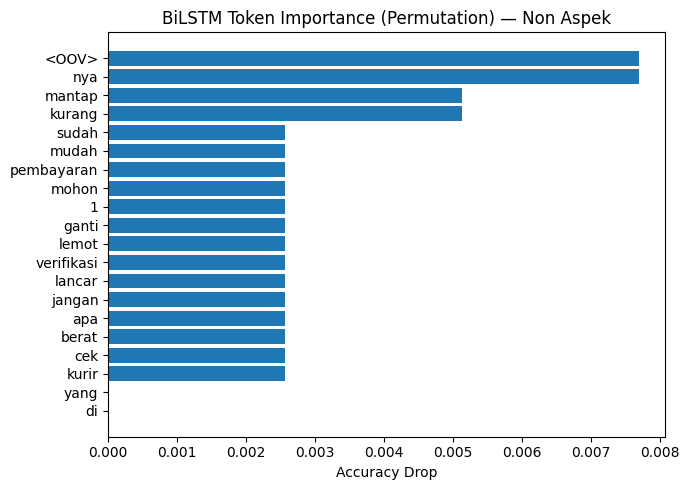


BiLSTM selesai.


In [ ]:
# ============================================================
# BiLSTM +Permutation Importance per Token (Final)
# ============================================================

def plot_loss(history_dict, model_name, aspek, save_prefix=None, ymin=None, ymax=None):
    plt.figure(figsize=(7, 5))

    for label, hist in history_dict.items():
        if "train" in hist:
            plt.plot(hist["train"], label=f"{label} Train")
        if "val" in hist:
            plt.plot(hist["val"], label=f"{label} Val", linestyle="--")

    plt.title(f"{model_name} Loss Curve — {aspek}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if ymin is not None or ymax is not None:
        plt.ylim(ymin, ymax)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



# =======================================================================
#                    BILSTM MAIN LOOP — FINAL VERSION
# =======================================================================
bilstm_results = {}

if DO_TRAIN_BILSTM and HAVE_TF:

    MAX_WORDS = 20000
    MAX_LEN   = 80
    EMB       = 64
    EPOCHS    = BILSTM_EPOCHS
    BATCH     = BILSTM_BATCH

    for aspek in LABEL_COLS:

        print(f"\n=== BiLSTM Aspek: {aspek} ===")
        d = df[df[aspek] != 0].copy()
        if len(d) < 20:
            print("  skip (too few data)")
            continue

        # -------------------------------
        # Train-test split
        # -------------------------------
        train, test = train_test_split(
            d, test_size=0.20,
            stratify=d[aspek],
            random_state=42
        )
        y_train = (train[aspek] == 1).astype(int)
        y_test  = (test[aspek] == 1).astype(int)

        # -------------------------------
        # Tokenizer
        # -------------------------------
        tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
        tok.fit_on_texts(train["text_clean"])

        seq = lambda x: pad_sequences(tok.texts_to_sequences(x), maxlen=MAX_LEN)
        Xtr = seq(train["text_clean"])
        Xte = seq(test["text_clean"])

        # ===========================================================
        # MODEL 1 — TEXT ONLY
        # ===========================================================
        inp = Input(shape=(MAX_LEN,))
        x = Embedding(MAX_WORDS, EMB)(inp)
        x = Bidirectional(LSTM(64))(x)
        x = Dense(32, activation='relu')(x)
        out = Dense(1, activation='sigmoid')(x)

        model1 = Model(inp, out)
        model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

        h1 = model1.fit(
            Xtr, y_train,
            epochs=EPOCHS, batch_size=BATCH,
            validation_split=0.1,
            verbose=1
        )

        pred1 = (model1.predict(Xte) >= 0.5).astype(int).ravel()
        m1 = metrics_per_class(y_test, pred1)


        # ===========================================================
        # MODEL 2 — TEXT + NUMERIC FEATURES
        # ===========================================================
        if feature_cols:
            Ft_tr = scaler.transform(preprocess_additional_features(train, feature_cols))
            Ft_te = scaler.transform(preprocess_additional_features(test, feature_cols))
        else:
            Ft_tr = Ft_te = np.zeros((len(train), 0))

        inp_t = Input(shape=(MAX_LEN,))
        inp_f = Input(shape=(Ft_tr.shape[1],))

        x = Embedding(MAX_WORDS, EMB)(inp_t)
        x = Bidirectional(LSTM(64))(x)
        concat = Concatenate()([x, inp_f])
        x = Dense(32, activation='relu')(concat)
        out = Dense(1, activation='sigmoid')(x)

        model2 = Model([inp_t, inp_f], out)
        model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

        h2 = model2.fit(
            [Xtr, Ft_tr], y_train,
            epochs=EPOCHS, batch_size=BATCH,
            validation_split=0.1,
            verbose=1
        )

        pred2 = (model2.predict([Xte, Ft_te]) >= 0.5).astype(int).ravel()
        m2 = metrics_per_class(y_test, pred2)

        bilstm_results[aspek] = {"no": m1, "with": m2}


        # ===========================================================
        # Metric + Loss Plot
        # ===========================================================
        plot_metric_scatter_line(m1, m2, "BiLSTM", aspek, "BiLSTM", ymin=0.7)

        histos = {
            "TextOnly": {"train": h1.history["loss"], "val": h1.history["val_loss"]},
            "Text+Feat": {"train": h2.history["loss"], "val": h2.history["val_loss"]},
        }
        plot_loss(histos, "BiLSTM", aspek)



        # ===========================================================
        # PER-TOKEN PERMUTATION IMPORTANCE
        # ===========================================================
        print("\n--- BiLSTM PERMUTATION IMPORTANCE — TOP TOKENS ---")

        # Base accuracy
        base_pred = (model2.predict([Xte, Ft_te]) >= 0.5).astype(int).ravel()
        base_acc = accuracy_score(y_test, base_pred)

        word_index = tok.word_index
        inv_index  = {v: k for k, v in word_index.items()}

        # Ambil 300 token paling sering
        top_tokens = sorted(word_index.items(), key=lambda x: x[1])[:300]

        importance = {}

        for word, idx in top_tokens:
            X_occ = Xte.copy()
            X_occ[X_occ == idx] = 0

            pred_occ = (model2.predict([X_occ, Ft_te]) >= 0.5).astype(int).ravel()
            acc_occ = accuracy_score(y_test, pred_occ)

            drop = base_acc - acc_occ
            importance[word] = drop

        imp_sorted = dict(sorted(importance.items(), key=lambda x: -x[1]))

        print("\nTOP-20 IMPORTANT TOKENS:")
        print(list(imp_sorted.items())[:20])


        # ===========================================================
        # Grafik bar chrt
        # ===========================================================
        plt.figure(figsize=(7, 5))
        plt.barh(list(imp_sorted.keys())[:20], list(imp_sorted.values())[:20])
        plt.gca().invert_yaxis()
        plt.title(f"BiLSTM Token Importance (Permutation) — {aspek}")
        plt.xlabel("Accuracy Drop")
        plt.tight_layout()
        plt.show()

        joblib.dump(
            imp_sorted,
            os.path.join(OUTPUT_DIR, f"bilstm_token_importance_{aspek}.joblib")
        )


        # ===========================================================
        # Save model
        # ===========================================================
        model1.save(os.path.join(OUTPUT_DIR, f"bilstm_{aspek}_textonly.h5"))
        model2.save(os.path.join(OUTPUT_DIR, f"bilstm_{aspek}_withfeat.h5"))

    print("\nBiLSTM selesai.")

else:
    print("Skipping BiLSTM…")


In [ ]:
def annotate_two_lines(ax, x, y1, y2, offset_up=0.015, offset_down=0.020):
    """
    Menuliskan angka tanpa tumpang tindih:
    nilai lebih tinggi → di atas
    nilai lebih rendah → di bawah
    """
    for xi, v1, v2 in zip(x, y1, y2):
        if v1 >= v2:
            ax.text(xi, v1 + offset_up, f"{v1:.3f}",
                    ha="center", va="bottom", fontsize=8)
            ax.text(xi, v2 - offset_down, f"{v2:.3f}",
                    ha="center", va="top", fontsize=8)
        else:
            ax.text(xi, v2 + offset_up, f"{v2:.3f}",
                    ha="center", va="bottom", fontsize=8)
            ax.text(xi, v1 - offset_down, f"{v1:.3f}",
                    ha="center", va="top", fontsize=8)


In [ ]:
def plot_bilstm_grid(bilstm_results):
    metrics = [
        "accuracy",
        "pos_precision","neg_precision",
        "pos_recall","neg_recall",
        "pos_f1","neg_f1"
    ]

    aspek_list = list(bilstm_results.keys())
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, aspek in enumerate(aspek_list):
        ax = axes[i]

        m_no   = bilstm_results[aspek]["no"]
        m_with = bilstm_results[aspek]["with"]

        y_no   = [m_no[m] for m in metrics]
        y_with = [m_with[m] for m in metrics]
        x = np.arange(len(metrics))

        ax.plot(x, y_no, marker='o', linewidth=2, label="Text Only")
        ax.plot(x, y_with, marker='s', linestyle='--', linewidth=2, label="Text + Feature")

        annotate_two_lines(ax, x, y_no, y_with)

        ax.set_title(aspek)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, fontsize=9)
        ax.set_ylim(0.6, 1.05)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(len(aspek_list), 6):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)

    fig.suptitle("Performa BiLSTM per Aspek (Scatter + Line)", fontsize=16)
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()


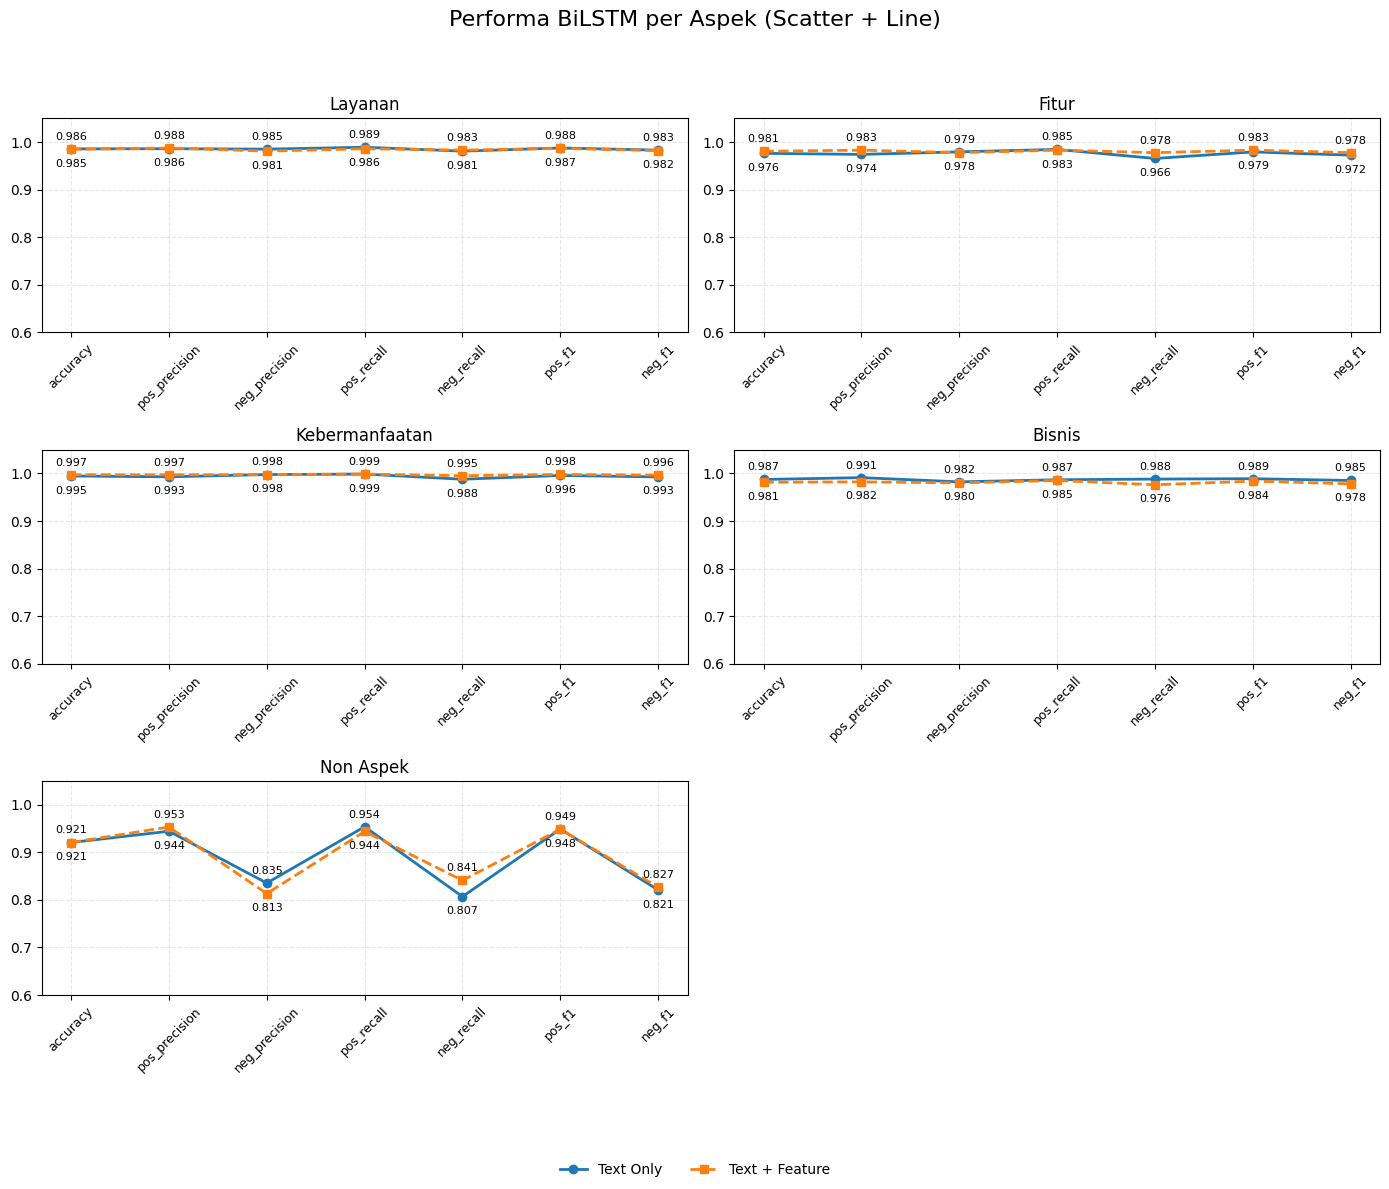

In [ ]:
plot_bilstm_grid(bilstm_results)


## IndoBERT

Device: cuda

Aspek: Layanan

--- Scenario: head_only


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.862533692722372
  Text-only perm_imp: {'text_clean': 0.3372267145852052}  baseacc: 0.862533692722372
  Text+Feat test acc: 0.9910152740341419
  Text+Feat perm_imp: {'text_clean': 0.46540880503144644, 'score': 0.00658879904162916}  baseacc: 0.9910152740341419

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0521
    sekali               : 0.0009
    bisa                 : 0.0009
    untuk                : 0.0009
    ini                  : 0.0009
    tapi                 : 0.0009
    jadi                 : 0.0009
    layanan              : 0.0000
    sangat               : 0.0000
    dengan               : 0.0000
    dan                  : 0.0000
    layanannya           : 0.0000
    mengecewakan         : 0.0000
    buruk                : 0.0000
    produk               : 0.0000
    harapan              : 0.0000
    oleh                 : 0.0000
    top     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.9919137466307277
  Text-only perm_imp: {'text_clean': 0.4863731656184486}  baseacc: 0.9919137466307277
  Text+Feat test acc: 0.9910152740341419
  Text+Feat perm_imp: {'text_clean': 0.46540880503144644, 'score': 0.00658879904162916}  baseacc: 0.9910152740341419

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0521
    sekali               : 0.0009
    bisa                 : 0.0009
    untuk                : 0.0009
    ini                  : 0.0009
    tapi                 : 0.0009
    jadi                 : 0.0009
    layanan              : 0.0000
    sangat               : 0.0000
    dengan               : 0.0000
    dan                  : 0.0000
    layanannya           : 0.0000
    mengecewakan         : 0.0000
    buruk                : 0.0000
    produk               : 0.0000
    harapan              : 0.0000
    oleh                 : 0.0000
    top   

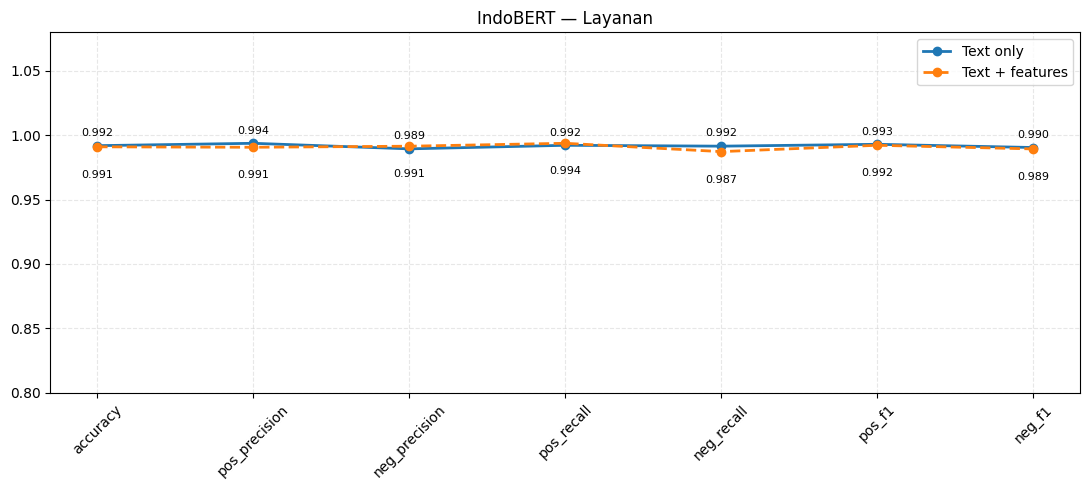

  saved: ./output_indobert/indobert_perm_feat_Layanan.png


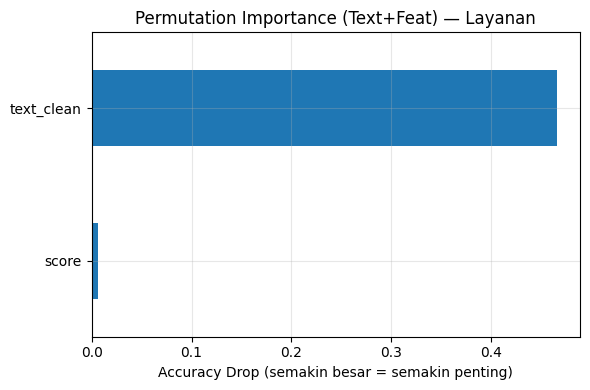

  saved: ./output_indobert/indobert_token_top20_Layanan.png


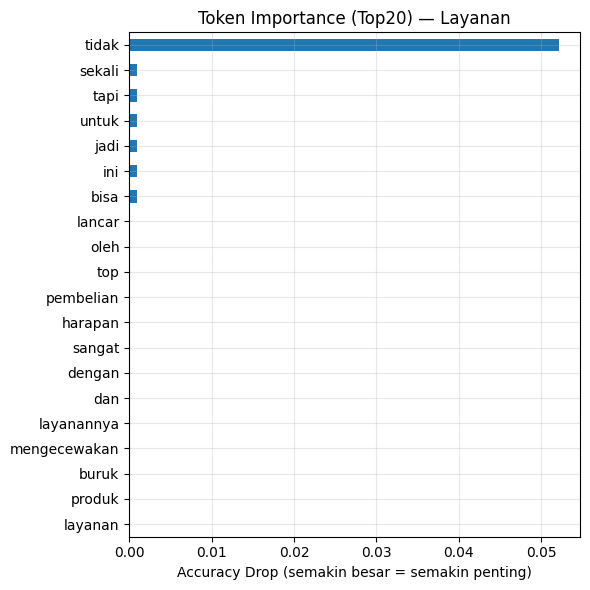

>>> Done aspek Layanan. Best scenario: last1

Aspek: Fitur

--- Scenario: head_only


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.8578947368421053
  Text-only perm_imp: {'text_clean': 0.3280701754385965}  baseacc: 0.8578947368421053
  Text+Feat test acc: 0.9885964912280701
  Text+Feat perm_imp: {'text_clean': 0.4657894736842105, 'score': 0.009649122807017463}  baseacc: 0.9885964912280701

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0342
    bisa                 : 0.0018
    bukalapak            : 0.0018
    sangat               : 0.0009
    bagus                : 0.0009
    terbantu             : 0.0009
    pembayaran           : 0.0009
    proses               : 0.0009
    di                   : 0.0009
    nya                  : 0.0009
    lagi                 : 0.0009
    tolong               : 0.0009
    fitur                : 0.0000
    dengan               : 0.0000
    fiturnya             : 0.0000
    sesuai               : 0.0000
    buruk                : 0.0000
    mengec

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.987719298245614
  Text-only perm_imp: {'text_clean': 0.4783625730994152}  baseacc: 0.987719298245614
  Text+Feat test acc: 0.9885964912280701
  Text+Feat perm_imp: {'text_clean': 0.4657894736842105, 'score': 0.009649122807017463}  baseacc: 0.9885964912280701

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0342
    bisa                 : 0.0018
    bukalapak            : 0.0018
    sangat               : 0.0009
    bagus                : 0.0009
    terbantu             : 0.0009
    pembayaran           : 0.0009
    proses               : 0.0009
    di                   : 0.0009
    nya                  : 0.0009
    lagi                 : 0.0009
    tolong               : 0.0009
    fitur                : 0.0000
    dengan               : 0.0000
    fiturnya             : 0.0000
    sesuai               : 0.0000
    buruk                : 0.0000
    mengecew

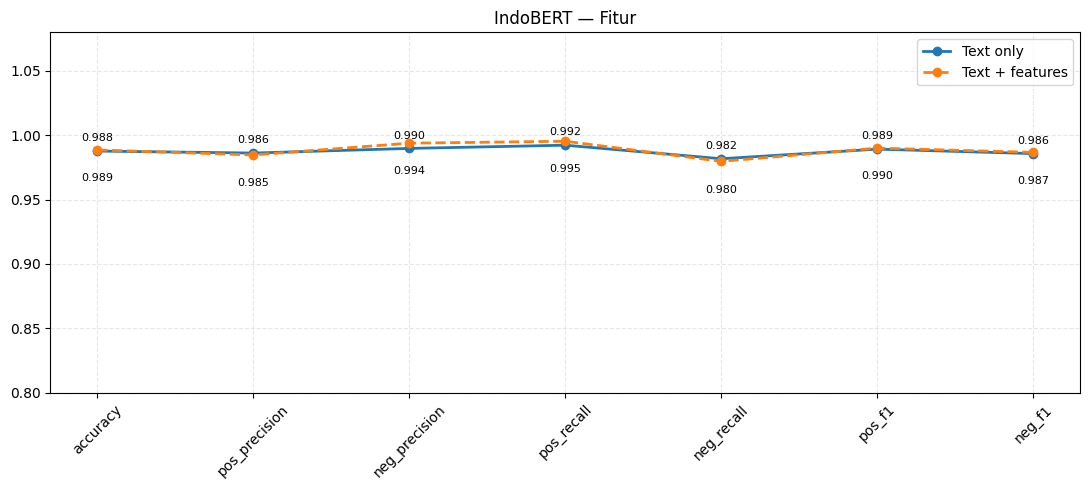

  saved: ./output_indobert/indobert_perm_feat_Fitur.png


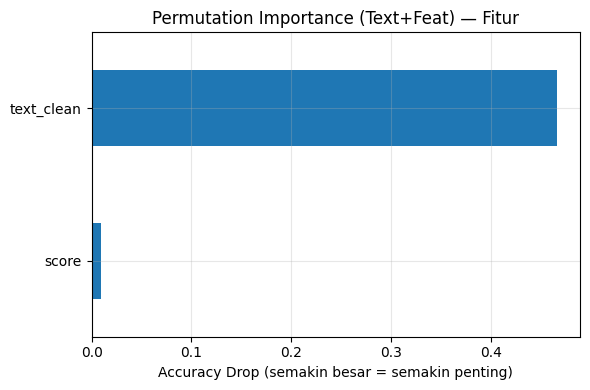

  saved: ./output_indobert/indobert_token_top20_Fitur.png


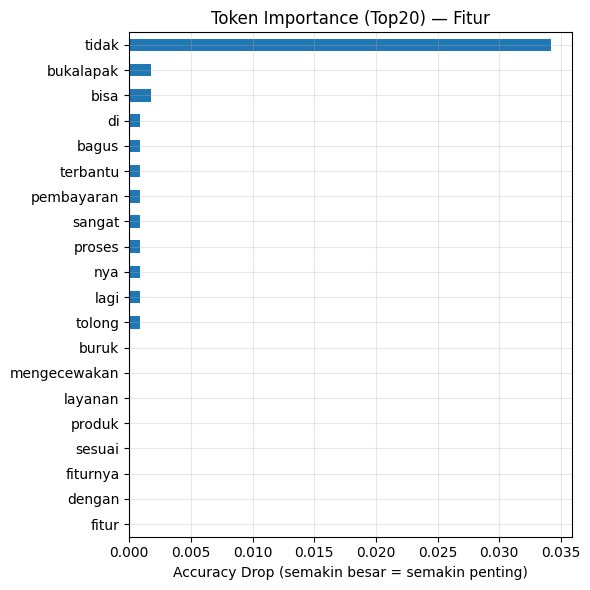

>>> Done aspek Fitur. Best scenario: last1

Aspek: Kebermanfaatan

--- Scenario: head_only


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.6933575978161965
  Text-only perm_imp: {'text_clean': 0.07703973309068853}  baseacc: 0.6933575978161965
  Text+Feat test acc: 0.9963603275705186
  Text+Feat perm_imp: {'text_clean': 0.46830451925993327, 'score': 0.0009099181073702889}  baseacc: 0.9963603275705186

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0009
    terbantu             : 0.0009
    kecewa               : 0.0009
    sangat               : 0.0000
    kegunaan             : 0.0000
    dengan               : 0.0000
    dan                  : 0.0000
    saya                 : 0.0000
    kegunaannya          : 0.0000
    sesuai               : 0.0000
    buruk                : 0.0000
    mengecewakan         : 0.0000
    layanan              : 0.0000
    bagus                : 0.0000
    produk               : 0.0000
    pembelian            : 0.0000
    sekali               : 0.0000
    har

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.9963603275705186
  Text-only perm_imp: {'text_clean': 0.4743706399757355}  baseacc: 0.9963603275705186
  Text+Feat test acc: 0.9963603275705186
  Text+Feat perm_imp: {'text_clean': 0.46830451925993327, 'score': 0.0009099181073702889}  baseacc: 0.9963603275705186

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0009
    terbantu             : 0.0009
    kecewa               : 0.0009
    sangat               : 0.0000
    kegunaan             : 0.0000
    dengan               : 0.0000
    dan                  : 0.0000
    saya                 : 0.0000
    kegunaannya          : 0.0000
    sesuai               : 0.0000
    buruk                : 0.0000
    mengecewakan         : 0.0000
    layanan              : 0.0000
    bagus                : 0.0000
    produk               : 0.0000
    pembelian            : 0.0000
    sekali               : 0.0000
    hara

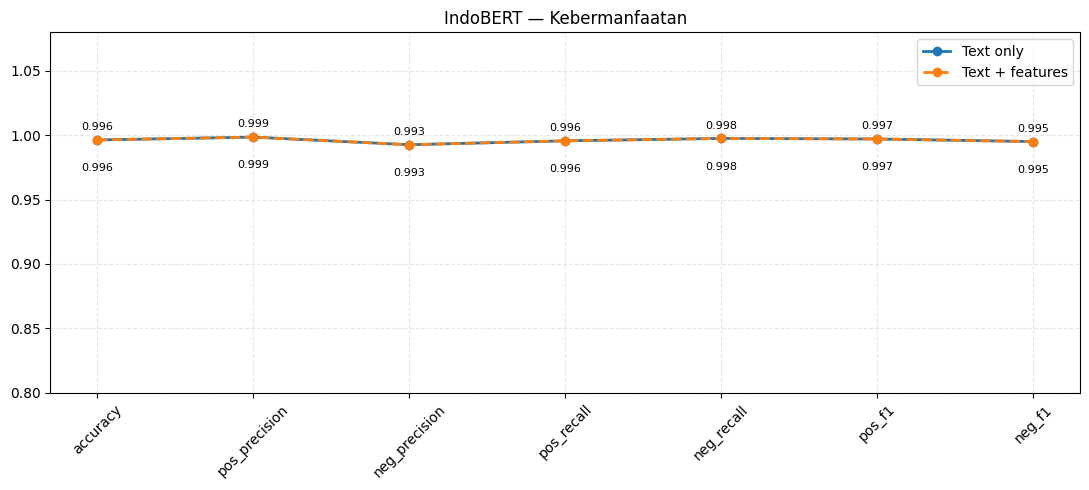

  saved: ./output_indobert/indobert_perm_feat_Kebermanfaatan.png


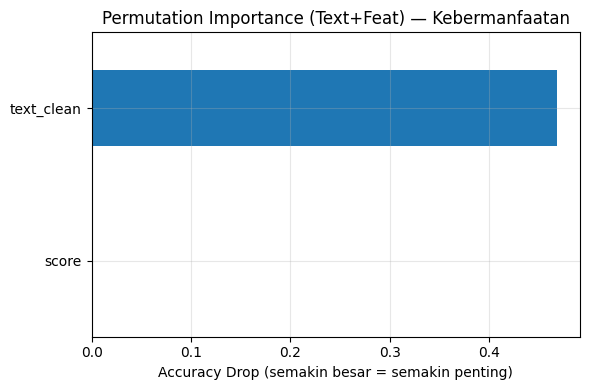

  saved: ./output_indobert/indobert_token_top20_Kebermanfaatan.png


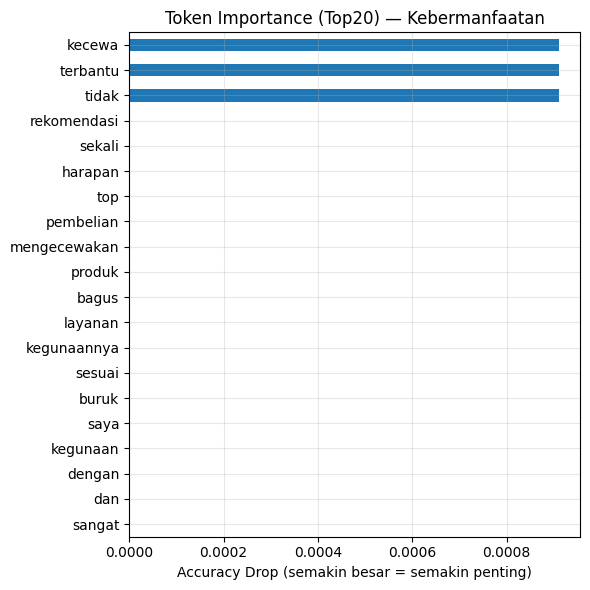

>>> Done aspek Kebermanfaatan. Best scenario: last1

Aspek: Bisnis

--- Scenario: head_only


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.8221276595744681
  Text-only perm_imp: {'text_clean': 0.275177304964539}  baseacc: 0.8221276595744681
  Text+Feat test acc: 0.9923404255319149
  Text+Feat perm_imp: {'text_clean': 0.4581560283687944, 'score': 0.008226950354609963}  baseacc: 0.9923404255319149

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0434
    sesuai               : 0.0051
    aplikasi             : 0.0009
    pembayaran           : 0.0000
    proses               : 0.0000
    bisnis               : 0.0000
    bisnisnya            : 0.0000
    buruk                : 0.0000
    mengecewakan         : 0.0000
    layanan              : 0.0000
    pembelian            : 0.0000
    top                  : 0.0000
    lancar               : 0.0000
    rekomendasi          : 0.0000
    produk               : 0.0000
    pelayanan            : 0.0000
    memuaskan            : 0.0000
    senang 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.9923404255319149
  Text-only perm_imp: {'text_clean': 0.46865248226950357}  baseacc: 0.9923404255319149
  Text+Feat test acc: 0.9923404255319149
  Text+Feat perm_imp: {'text_clean': 0.4581560283687944, 'score': 0.008226950354609963}  baseacc: 0.9923404255319149

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    tidak                : 0.0434
    sesuai               : 0.0051
    aplikasi             : 0.0009
    pembayaran           : 0.0000
    proses               : 0.0000
    bisnis               : 0.0000
    bisnisnya            : 0.0000
    buruk                : 0.0000
    mengecewakan         : 0.0000
    layanan              : 0.0000
    pembelian            : 0.0000
    top                  : 0.0000
    lancar               : 0.0000
    rekomendasi          : 0.0000
    produk               : 0.0000
    pelayanan            : 0.0000
    memuaskan            : 0.0000
    senan

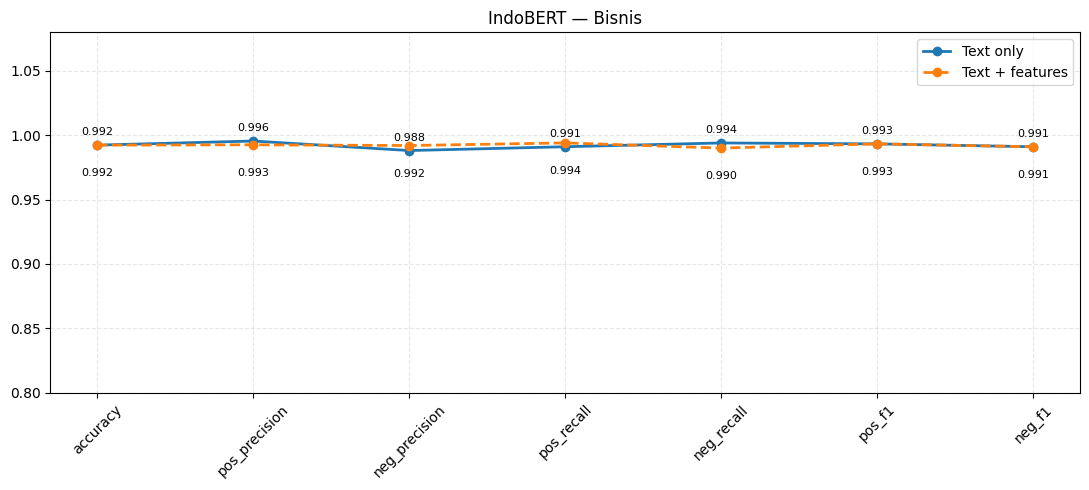

  saved: ./output_indobert/indobert_perm_feat_Bisnis.png


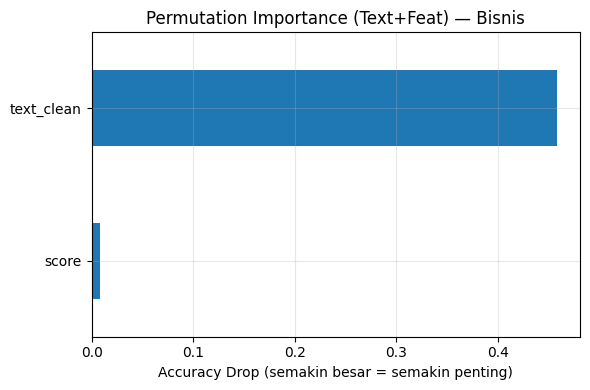

  saved: ./output_indobert/indobert_token_top20_Bisnis.png


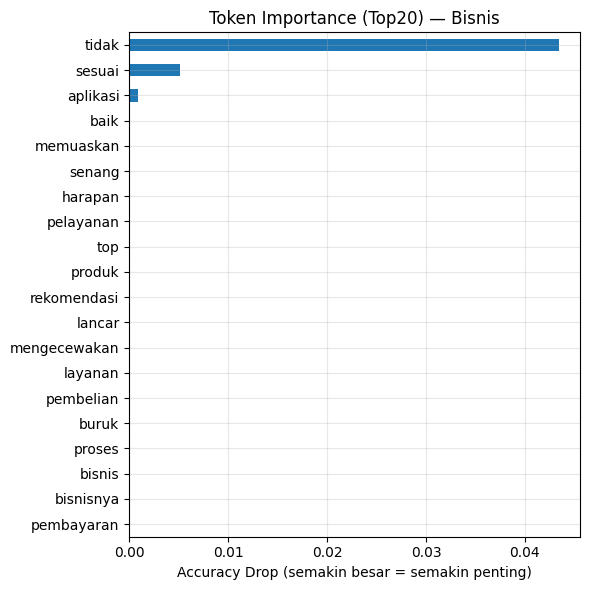

>>> Done aspek Bisnis. Best scenario: last1

Aspek: Non Aspek

--- Scenario: head_only


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.7897435897435897
  Text-only perm_imp: {'text_clean': 0.04871794871794869}  baseacc: 0.7897435897435897
  Text+Feat test acc: 0.941025641025641
  Text+Feat perm_imp: {'text_clean': 0.26837606837606837, 'score': 0.029059829059829068}  baseacc: 0.941025641025641

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    kenapa               : 0.0051
    oke                  : 0.0026
    lagi                 : 0.0026
    untuk                : 0.0026
    bagus                : 0.0026
    gak                  : 0.0026
    gk                   : 0.0026
    ada                  : 0.0000
    yang                 : 0.0000
    di                   : 0.0000
    saya                 : 0.0000
    cukup                : 0.0000
    spesial              : 0.0000
    netral               : 0.0000
    menonjol             : 0.0000
    dan                  : 0.0000
    saja                 : 0.0000
    biasa 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Text-only test acc: 0.9358974358974359
  Text-only perm_imp: {'text_clean': 0.28547008547008546}  baseacc: 0.9358974358974359
  Text+Feat test acc: 0.941025641025641
  Text+Feat perm_imp: {'text_clean': 0.26837606837606837, 'score': 0.029059829059829068}  baseacc: 0.941025641025641

  Calculating token-level importance (will take time) ... (candidates: 80)
  Top-20 token importance (word -> accuracy-drop):
    kenapa               : 0.0051
    oke                  : 0.0026
    lagi                 : 0.0026
    untuk                : 0.0026
    bagus                : 0.0026
    gak                  : 0.0026
    gk                   : 0.0026
    ada                  : 0.0000
    yang                 : 0.0000
    di                   : 0.0000
    saya                 : 0.0000
    cukup                : 0.0000
    spesial              : 0.0000
    netral               : 0.0000
    menonjol             : 0.0000
    dan                  : 0.0000
    saja                 : 0.0000
    biasa 

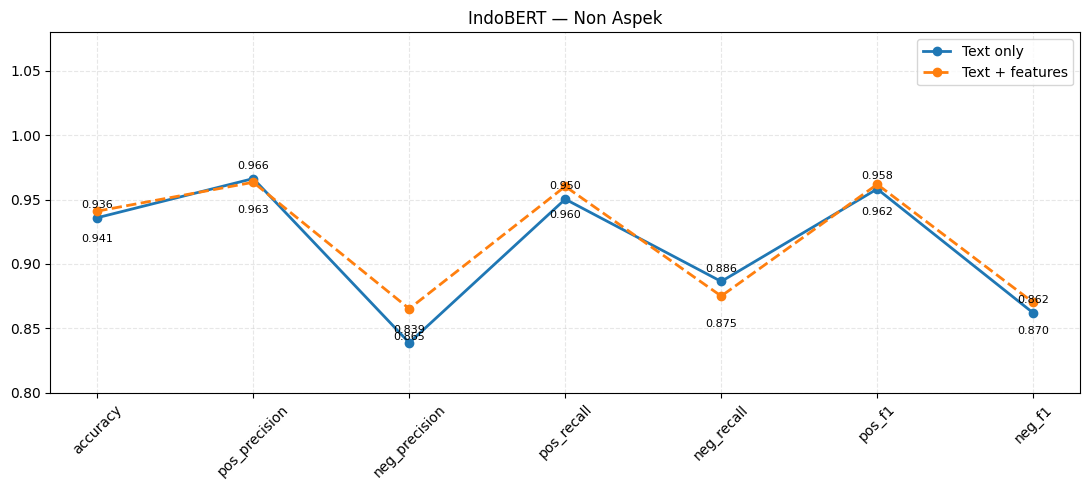

  saved: ./output_indobert/indobert_perm_feat_Non Aspek.png


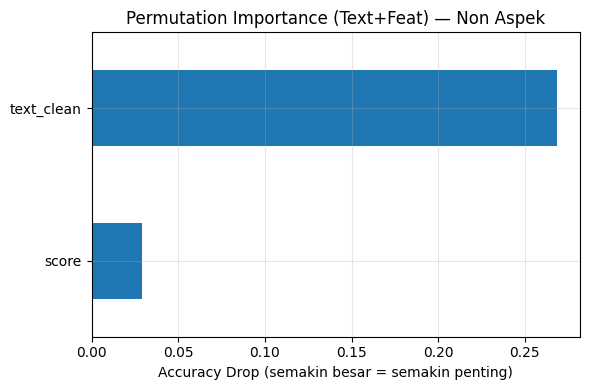

  saved: ./output_indobert/indobert_token_top20_Non Aspek.png


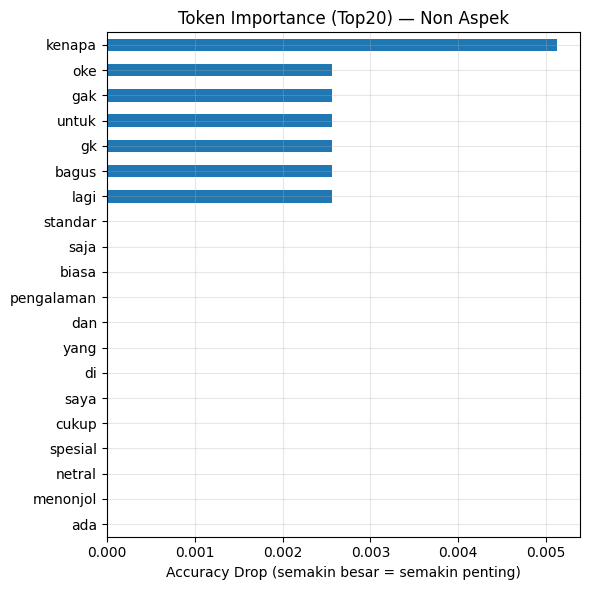

>>> Done aspek Non Aspek. Best scenario: last1

=== Summary best scenario per aspek ===
- Layanan: best=last1, text_only_acc=0.9919, text+feat_acc=0.9910
- Fitur: best=last1, text_only_acc=0.9877, text+feat_acc=0.9886
- Kebermanfaatan: best=last1, text_only_acc=0.9964, text+feat_acc=0.9964
- Bisnis: best=last1, text_only_acc=0.9923, text+feat_acc=0.9923
- Non Aspek: best=last1, text_only_acc=0.9359, text+feat_acc=0.9410

IndoBERT experiments finished. Results saved to ./output_indobert


In [ ]:
# ================= INDOBERT — Fine-tune + TextOnly vs Text+Features + Importance =================

# ---------- Imports ----------
import os, joblib, torch, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

# ---------- Config (ubah sesuai kebutuhan) ----------
DO_FINE_TUNE_INDOBERT = True
BERT_MODEL = "indobenchmark/indobert-base-p1"
INDOBERT_FT_EPOCHS = 2        # ubah sesuai resource
INDOBERT_FT_LR = 2e-5
OUTPUT_DIR = "./output_indobert"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fitur numerik tambahan yang ingin dipakai (pastikan kolom ini ada di df)
feature_cols = ["score"]   # ubah sesuai dataset Anda (bisa lebih dari 1)

# ---------- Helpers: metrics & permutation importance ----------
from sklearn.metrics import precision_recall_fscore_support

def metrics_per_class(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[1,0], zero_division=0
    )
    return {
        "accuracy": float(acc),
        "pos_precision": float(prec[0]),
        "neg_precision": float(prec[1]),
        "pos_recall": float(rec[0]),
        "neg_recall": float(rec[1]),
        "pos_f1": float(f1[0]),
        "neg_f1": float(f1[1]),
    }

def permutation_importance_df(predict_fn, X_df, y_true, feat_list, n_repeats=3, random_state=42):
    rng = np.random.RandomState(random_state)
    base_preds = predict_fn(X_df)
    base_acc = accuracy_score(y_true, base_preds)
    importances = {}
    for feat in feat_list:
        drops = []
        for _ in range(n_repeats):
            X_shuf = X_df.copy().reset_index(drop=True)
            # shuffle column values (works for text or numeric column)
            X_shuf[feat] = X_shuf[feat].sample(frac=1.0, random_state=rng.randint(0, 1_000_000)).reset_index(drop=True)
            preds = predict_fn(X_shuf)
            drops.append(base_acc - accuracy_score(y_true, preds))
        importances[feat] = float(np.mean(drops))
    importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
    return importances, float(base_acc)

# ---------- Plot helpers ----------
def plot_bar_importance(imp_dict, title, out_path=None, figsize=(6,4)):
    if (not imp_dict) or (sum(imp_dict.values()) == 0):
        print("  (No importance values or all zeros)")
        return
    plt.figure(figsize=figsize)
    s = pd.Series(imp_dict)
    s.sort_values(ascending=True).plot(kind="barh")
    plt.title(title)
    plt.xlabel("Accuracy Drop (semakin besar = semakin penting)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print("  saved:", out_path)
    plt.show()
    plt.close()

def plot_metric_scatter_line_fixed(metrics_no, metrics_with, aspek, modelname):
    metrics = ["accuracy","pos_precision","neg_precision","pos_recall","neg_recall","pos_f1","neg_f1"]
    x = np.arange(len(metrics))
    y1 = [metrics_no.get(m,0) for m in metrics]
    y2 = [metrics_with.get(m,0) for m in metrics]
    plt.figure(figsize=(11,5))
    plt.plot(x, y1, marker='o', label='Text only', linewidth=2)
    plt.plot(x, y2, marker='o', linestyle='--', label='Text + features', linewidth=2)
    plt.xticks(x, metrics, rotation=45)
    plt.ylim(0.8, 1.08)   # sesuai permintaan
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.title(f"{modelname} — {aspek}")
    plt.legend()
    ax = plt.gca()
    # tambahkan label nilai pada titik dengan offset zig-zag agar tidak tumpang tindih
    for i, (a,b) in enumerate(zip(y1,y2)):
        ax.text(i, a + 0.006, f"{a:.3f}", ha='center', va='bottom', fontsize=8)
        ax.text(i, b - 0.018, f"{b:.3f}", ha='center', va='top', fontsize=8)
    plt.tight_layout()
    plt.show()

# ---------- Tokenizer & models helpers ----------
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

def prepare_ds(df_subset, label_col, max_length=160):
    d = df_subset.copy()
    d["label"] = d[label_col].apply(lambda v: 1 if v == 1 else 0)
    texts = d["text_clean"].astype(str).tolist()
    enc = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)
    ds = Dataset.from_dict({
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": np.array(d["label"].values)
    })
    ds = ds.with_format(type="torch", columns=["input_ids","attention_mask","labels"])
    return ds

def batched_predict_from_model(model, texts, batch_size=32, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    if not isinstance(texts, list):
        texts = list(texts)
    out = []
    model.eval()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=160, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        out.extend(preds.tolist())
    return np.array(out)

# function to get pooled embeddings (CLS / pooled output) from base model
def get_pooled_embeddings(model_backbone, texts, batch_size=32, device=None):
    """
    model_backbone: AutoModel (not sequence classification head) or model.base_model
    returns: numpy array (n_samples, hidden_size)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model_backbone.eval()
    out_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=160, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            # prefer pooled output when available
            res = model_backbone(**enc)
            if hasattr(res, "pooler_output"):
                pooled = res.pooler_output  # (batch, hidden)
            elif hasattr(res, "last_hidden_state"):
                pooled = res.last_hidden_state[:,0,:]  # CLS token
            else:
                pooled = res[0][:,0,:]
        out_embs.append(pooled.cpu().numpy())
    return np.vstack(out_embs)

# ---------- MAIN: Fine-tune per-aspek + both-scenarios + importance ----------
if not DO_FINE_TUNE_INDOBERT:
    print("DO_FINE_TUNE_INDOBERT is False — skipped.")
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    scenarios = {"head_only": 0, "last1": 1}   # Anda bisa tambahkan last2
    aspects_best_info = {}
    overall_plot_hist = {}

    for aspek in LABEL_COLS:
        print("\n" + "="*60)
        print("Aspek:", aspek)

        df_as = df[df[aspek] != 0].copy()
        if len(df_as) < 30:
            print("  skip (too few rows):", len(df_as))
            continue

        # split
        train_all, test_all = train_test_split(df_as, test_size=0.20, stratify=df_as[aspek], random_state=42)
        train_set, val_set = train_test_split(train_all, test_size=0.10, stratify=train_all[aspek], random_state=42)

        train_ds = prepare_ds(train_set, aspek)
        val_ds = prepare_ds(val_set, aspek)
        test_texts = test_all["text_clean"].astype(str).tolist()
        y_test = (test_all[aspek] == 1).astype(int).values

        # prepare numeric features (fit scaler on train)
        if feature_cols:
            scaler = StandardScaler()
            Xf_train = preprocess_df_feats = None
            Xf_train = train_set[feature_cols].astype(float).values
            scaler.fit(Xf_train)
        else:
            scaler = None

        scenario_results = {}

        for s_name, unfreeze in scenarios.items():
            print(f"\n--- Scenario: {s_name}")
            # load sequence classification model for fine-tuning
            model_cls = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2).to(device)

            # freeze parameters and unfreeze classifier head and optionally last layers
            for p in model_cls.parameters(): p.requires_grad = False
            if hasattr(model_cls, "classifier"):
                for p in model_cls.classifier.parameters(): p.requires_grad = True

            # locate encoder layers and unfreeze last `unfreeze`
            if unfreeze > 0:
                encoder_layers = None
                if hasattr(model_cls, "base_model") and hasattr(model_cls.base_model, "encoder"):
                    encoder_layers = model_cls.base_model.encoder.layer
                elif hasattr(model_cls, "bert") and hasattr(model_cls.bert, "encoder"):
                    encoder_layers = model_cls.bert.encoder.layer
                if encoder_layers is not None:
                    total = len(encoder_layers)
                    for i in range(total - unfreeze, total):
                        for p in encoder_layers[i].parameters():
                            p.requires_grad = True

            use_fp16 = torch.cuda.is_available()
            training_args = TrainingArguments(
                output_dir=os.path.join(OUTPUT_DIR, f"ft_{aspek}_{s_name}"),
                num_train_epochs=INDOBERT_FT_EPOCHS,
                per_device_train_batch_size=16 if use_fp16 else 8,
                per_device_eval_batch_size=16 if use_fp16 else 8,
                learning_rate=INDOBERT_FT_LR,
                logging_steps=40,
                report_to=[],
                fp16=use_fp16,
                save_strategy="no"
            )

            def compute_metrics_fn(pred):
                logits, labels = pred
                preds = np.argmax(logits, axis=1)
                return {"accuracy": accuracy_score(labels, preds)}

            trainer = Trainer(
                model=model_cls,
                args=training_args,
                train_dataset=train_ds,
                eval_dataset=val_ds,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics_fn
            )

            trainer.train()

            # capture losses
            logs = trainer.state.log_history
            tr_losses = [x["loss"] for x in logs if "loss" in x]
            val_losses = [x["eval_loss"] for x in logs if "eval_loss" in x]
            if len(val_losses) == 0 and len(tr_losses) > 0:
                val_losses = [min(tr_losses)]

            # ---------------- Text-only evaluation (use trainer.model) ----------------
            hf_model = trainer.model.to(device)
            pred_text_only = lambda Xdf: batched_predict_from_model(hf_model, Xdf["text_clean"].astype(str).tolist(), batch_size=32, device=device)

            y_pred_text = pred_text_only(test_all[["text_clean"]])
            m_text = metrics_per_class(y_test, y_pred_text)
            print("  Text-only test acc:", m_text["accuracy"])

            # permutation importance for text-only (shuffle text)
            X_for_perm_text = test_all[["text_clean"]].reset_index(drop=True)
            perm_text, base_text = permutation_importance_df(
                predict_fn=pred_text_only,
                X_df=X_for_perm_text,
                y_true=y_test,
                feat_list=["text_clean"],
                n_repeats=3
            )
            print("  Text-only perm_imp:", perm_text, " baseacc:", base_text)

            # ---------------- Text+features evaluation (pooled embeddings + classifier) --------------
            # get backbone model (without classification head) for embeddings
            # load a fresh AutoModel base to extract pooled outputs (smaller mem conflict)
            model_backbone = AutoModel.from_pretrained(BERT_MODEL).to(device)
            # get pooled embeddings for train/val/test
            texts_train = train_set["text_clean"].astype(str).tolist()
            texts_val = val_set["text_clean"].astype(str).tolist()
            texts_test = test_all["text_clean"].astype(str).tolist()

            emb_train = get_pooled_embeddings(model_backbone, texts_train, batch_size=32, device=device)
            emb_val = get_pooled_embeddings(model_backbone, texts_val, batch_size=32, device=device)
            emb_test = get_pooled_embeddings(model_backbone, texts_test, batch_size=32, device=device)

            # prepare numeric features (scaled)
            if feature_cols:
                Xf_tr = scaler.transform(train_set[feature_cols].astype(float).values)
                Xf_val = scaler.transform(val_set[feature_cols].astype(float).values)
                Xf_te = scaler.transform(test_all[feature_cols].astype(float).values)
            else:
                Xf_tr = np.zeros((len(emb_train), 0))
                Xf_val = np.zeros((len(emb_val), 0))
                Xf_te = np.zeros((len(emb_test), 0))

            # concat pooled embeddings + numeric features
            X_tr_cls = np.hstack([emb_train, Xf_tr])
            X_val_cls = np.hstack([emb_val, Xf_val])
            X_te_cls = np.hstack([emb_test, Xf_te])

            # train simple classifier (Logistic Regression)
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_tr_cls, (train_set[aspek] == 1).astype(int).values)

            y_pred_with = clf.predict(X_te_cls)
            m_with = metrics_per_class(y_test, y_pred_with)
            print("  Text+Feat test acc:", m_with["accuracy"])

            # permutation importance for numeric features + text (text perm by shuffling raw text, not pooled)
            # we measure importance over: ["text_clean"] + feature_cols
            def pred_wrapper_perm(Xdf):
                # if text changed, produce pooled embeddings for new text values (slow); else reuse
                texts = Xdf["text_clean"].astype(str).tolist()
                emb = get_pooled_embeddings(model_backbone, texts, batch_size=32, device=device)
                if feature_cols:
                    feats = scaler.transform(Xdf[feature_cols].astype(float).values)
                else:
                    feats = np.zeros((len(emb),0))
                Xc = np.hstack([emb, feats])
                return clf.predict(Xc)

            feat_list_perm = ["text_clean"] + feature_cols
            perm_with, base_with = permutation_importance_df(
                predict_fn=pred_wrapper_perm,
                X_df=test_all[["text_clean"] + feature_cols].reset_index(drop=True),
                y_true=y_test,
                feat_list=feat_list_perm,
                n_repeats=3
            )
            print("  Text+Feat perm_imp:", perm_with, " baseacc:", base_with)

            # ---------------- Token-level importance (word-level) — show top words like requested --------------
            # Candidate tokens from train corpus
            corpus_tokens = []
            for t in texts_test:
                corpus_tokens.extend(re.findall(r"\w+", str(t).lower()))
            token_freq = Counter(corpus_tokens)
            candidates = [w for w,_ in token_freq.most_common(200)]  # top-200 tokens
            # Evaluate occlusion on top-K (limit to 80 for speed)
            K = min(80, len(candidates))
            candidates = candidates[:K]

            token_importance = {}
            base_preds_te = clf.predict(X_te_cls)
            base_acc_te = accuracy_score(y_test, base_preds_te)

            print("\n  Calculating token-level importance (will take time) ... (candidates: {})".format(len(candidates)))
            for tok_word in candidates:
                # remove token occurrences from texts_test
                texts_occl = [re.sub(rf'\b{re.escape(tok_word)}\b', '', t, flags=re.IGNORECASE).strip() for t in texts_test]
                emb_occl = get_pooled_embeddings(model_backbone, texts_occl, batch_size=32, device=device)
                if feature_cols:
                    feats = Xf_te
                else:
                    feats = np.zeros((len(emb_occl),0))
                Xc_occl = np.hstack([emb_occl, feats])
                preds_occl = clf.predict(Xc_occl)
                acc_occl = accuracy_score(y_test, preds_occl)
                token_importance[tok_word] = base_acc_te - acc_occl

            token_importance = dict(sorted(token_importance.items(), key=lambda x: x[1], reverse=True))
            top_tokens20 = dict(list(token_importance.items())[:20])
            print("  Top-20 token importance (word -> accuracy-drop):")
            for w,v in list(top_tokens20.items()):
                print(f"    {w:20s} : {v:.4f}")

            # Save everything
            scenario_results[s_name] = {
                "train": tr_losses,
                "val": val_losses,
                "text_only_metrics": m_text,
                "text_only_perm": perm_text,
                "textfeat_metrics": m_with,
                "textfeat_perm": perm_with,
                "token_importance_top20": top_tokens20,
                "base_text_only": base_text,
                "base_textfeat": base_with
            }

            # cleanup per scenario
            del trainer
            del hf_model
            del model_backbone
            del clf
            torch.cuda.empty_cache()
            time.sleep(0.5)

        # select best scenario based on min val loss (if available)
        best_scenario = None
        best_val = float("inf")
        for s_name, info in scenario_results.items():
            vl = info.get("val", [])
            if len(vl) == 0:
                continue
            min_v = min(vl)
            if min_v < best_val:
                best_val = min_v
                best_scenario = s_name
        if best_scenario is None:
            best_scenario = list(scenario_results.keys())[0]

        aspects_best_info[aspek] = {
            "best": best_scenario,
            "min_val_loss": best_val,
            "info": scenario_results[best_scenario]
        }

        # Save per-aspek results & plots
        joblib.dump(scenario_results, os.path.join(OUTPUT_DIR, f"indobert_scenarios_{aspek}.joblib"))
        joblib.dump(aspects_best_info[aspek], os.path.join(OUTPUT_DIR, f"indobert_best_{aspek}.joblib"))

        # Plot comparison chart (text-only vs text+feat)
        plot_metric_scatter_line_fixed(
            aspects_best_info[aspek]["info"]["text_only_metrics"],
            aspects_best_info[aspek]["info"]["textfeat_metrics"],
            aspek, "IndoBERT"
        )

        # Plot permutation importance (numeric + text aggregate)
        plot_bar_importance(aspects_best_info[aspek]["info"]["textfeat_perm"],
                            f"Permutation Importance (Text+Feat) — {aspek}",
                            out_path=os.path.join(OUTPUT_DIR, f"indobert_perm_feat_{aspek}.png"))

        # Plot token importance top20
        plot_bar_importance(aspects_best_info[aspek]["info"]["token_importance_top20"],
                            f"Token Importance (Top20) — {aspek}",
                            out_path=os.path.join(OUTPUT_DIR, f"indobert_token_top20_{aspek}.png"),
                            figsize=(6,6))

        print(f">>> Done aspek {aspek}. Best scenario: {best_scenario}")

    # summary
    print("\n=== Summary best scenario per aspek ===")
    for aspek, info in aspects_best_info.items():
        acc_text = info["info"]["text_only_metrics"]["accuracy"]
        acc_with = info["info"]["textfeat_metrics"]["accuracy"]
        print(f"- {aspek}: best={info['best']}, text_only_acc={acc_text:.4f}, text+feat_acc={acc_with:.4f}")

    print("\nIndoBERT experiments finished. Results saved to", OUTPUT_DIR)


In [ ]:
def plot_indobert_grid(aspects_best_info):
    metrics = [
        "accuracy",
        "pos_precision","neg_precision",
        "pos_recall","neg_recall",
        "pos_f1","neg_f1"
    ]

    aspek_list = list(aspects_best_info.keys())
    fig, axes = plt.subplots(2, 3, figsize=(19, 8))
    axes = axes.flatten()

    for i, aspek in enumerate(aspek_list):
        ax = axes[i]

        info = aspects_best_info[aspek]["info"]
        m_no   = info["text_only_metrics"]
        m_with = info["textfeat_metrics"]

        y_no   = [m_no[m] for m in metrics]
        y_with = [m_with[m] for m in metrics]
        x = np.arange(len(metrics))

        ax.plot(x, y_no, marker='o', linewidth=2, label="Text Only")
        ax.plot(x, y_with, marker='s', linestyle='--', linewidth=2, label="Text + Feature")

        annotate_two_lines(ax, x, y_no, y_with)

        ax.set_title(f"{aspek}\n(best: {aspects_best_info[aspek]['best']})", fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, fontsize=9)
        ax.set_ylim(0.7, 1.05)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(len(aspek_list), 6):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)

    fig.suptitle("Performa IndoBERT per Aspek (Scatter + Line)", fontsize=16)
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.show()


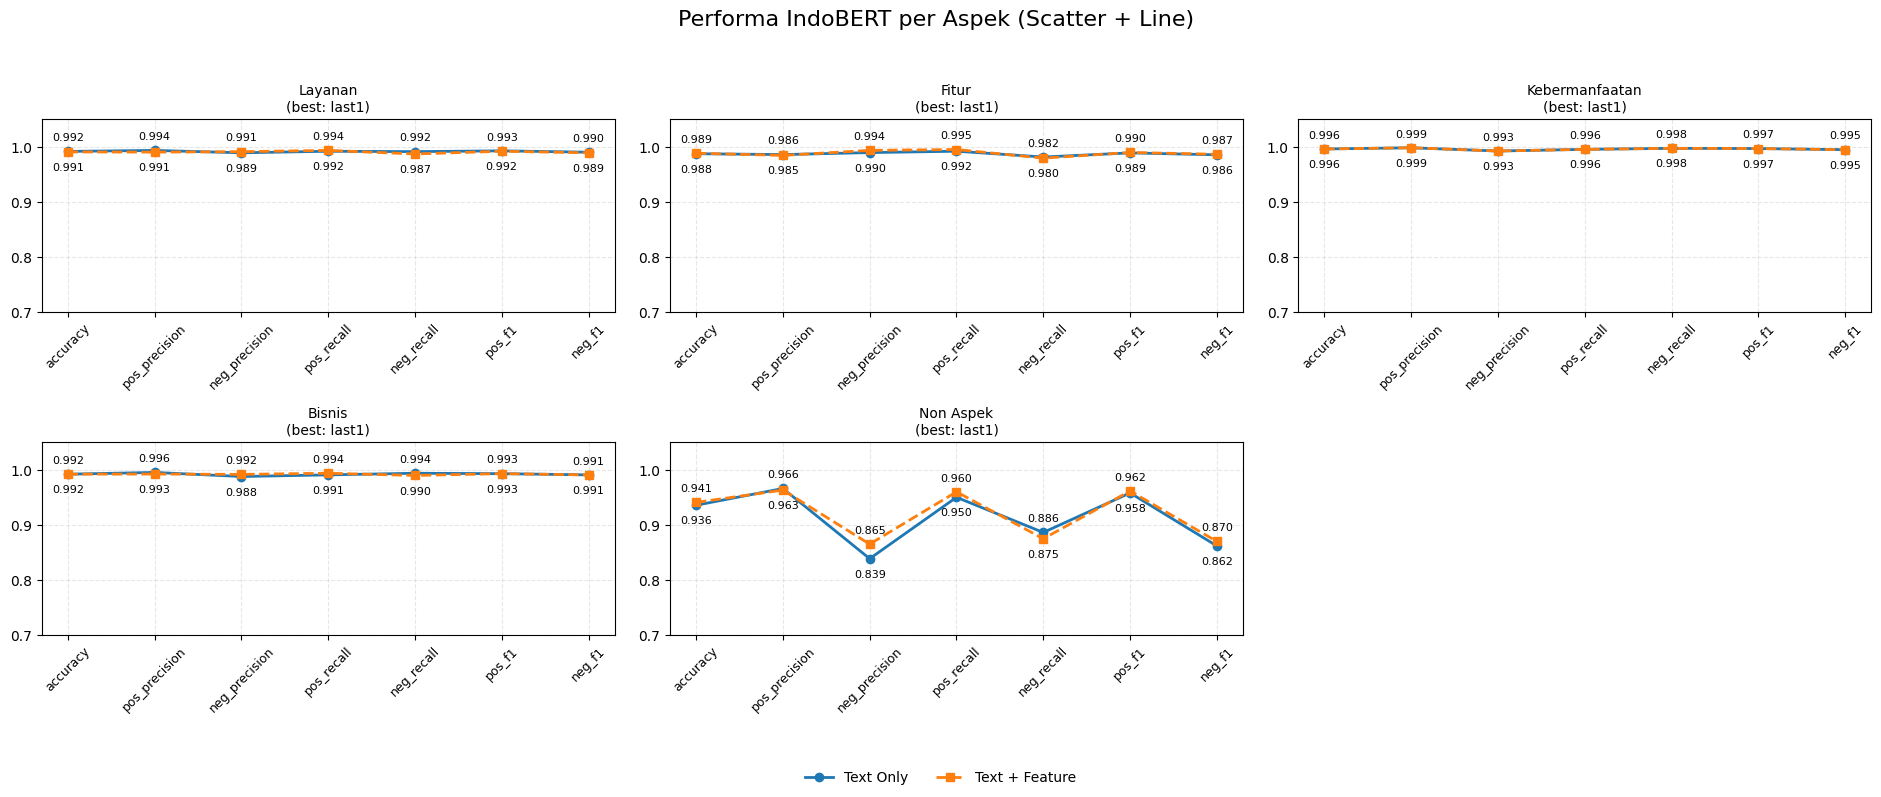

In [ ]:
plot_indobert_grid(aspects_best_info)


## Evaluation

In [ ]:
import pandas as pd

# ==============================
# 1. Extract SVM Results
# ==============================
svm_summary = {}

for aspek, vals in GLOBAL_RESULTS["SVM"].items():
    svm_summary[aspek] = {
        "svm_textonly_acc":  vals["no_feat"]["accuracy"],
        "svm_withfeat_acc": vals["with_feat"]["accuracy"],
    }


# ==============================
# 2. Extract BiLSTM Results
# ==============================
bilstm_summary = {}

for aspek, vals in bilstm_results.items():
    bilstm_summary[aspek] = {
        "bilstm_textonly_acc": vals["no"]["accuracy"],
        "bilstm_withfeat_acc": vals["with"]["accuracy"],
    }


# ==============================
# 3. Extract IndoBERT Results (best scenario)
# ==============================
bert_summary = {}

for aspek, vals in aspects_best_info.items():
    bert_summary[aspek] = {
        "indobert_textonly_acc": vals["info"]["text_only_metrics"]["accuracy"],
        "indobert_withfeat_acc": vals["info"]["textfeat_metrics"]["accuracy"],
        "best_scenario": vals["best"],
    }


# ==============================
# 4. Gabungkan Ketiga Metode
# ==============================
all_aspek = LABEL_COLS

rows = []

for aspek in all_aspek:
    row = {"aspek": aspek}

    # SVM
    if aspek in svm_summary:
        row.update(svm_summary[aspek])
    else:
        row.update({"svm_textonly_acc": None, "svm_withfeat_acc": None})

    # BiLSTM
    if aspek in bilstm_summary:
        row.update(bilstm_summary[aspek])
    else:
        row.update({"bilstm_textonly_acc": None, "bilstm_withfeat_acc": None})

    # IndoBERT
    if aspek in bert_summary:
        row.update(bert_summary[aspek])
    else:
        row.update({
            "indobert_textonly_acc": None,
            "indobert_withfeat_acc": None,
            "best_scenario": None
        })

    rows.append(row)

# Buat DataFrame
df_summary = pd.DataFrame(rows)

# Tampilkan
df_summary

import pandas as pd

# =============================
# SIAPKAN LIST ASPEK
# =============================
aspek_list = list(GLOBAL_RESULTS["SVM"].keys())

# =============================
# TABEL 1 – HASIL PER SKENARIO
# =============================
data_skenario = {
    "Aspek": [],

    # SVM
    "SVM_TextOnly": [],
    "SVM_TextFeat": [],

    # BiLSTM
    "BiLSTM_TextOnly": [],
    "BiLSTM_TextFeat": [],

    # IndoBERT
    "BERT_TextOnly": [],
    "BERT_TextFeat": [],
}

for aspek in aspek_list:

    # ---------------- SVM ----------------
    svm_no = GLOBAL_RESULTS["SVM"][aspek]["no_feat"]["accuracy"]
    svm_with = GLOBAL_RESULTS["SVM"][aspek]["with_feat"]["accuracy"]

    # ---------------- BiLSTM ----------------
    if aspek in bilstm_results:
        bil_no = bilstm_results[aspek]["no"]["accuracy"]
        bil_with = bilstm_results[aspek]["with"]["accuracy"]
    else:
        bil_no = None
        bil_with = None

    # ---------------- IndoBERT ----------------
    if aspek in aspects_best_info:
        bert_no = aspects_best_info[aspek]["info"]["text_only_metrics"]["accuracy"]
        bert_with = aspects_best_info[aspek]["info"]["textfeat_metrics"]["accuracy"]
    else:
        bert_no = None
        bert_with = None

    # simpan ke tabel skenario
    data_skenario["Aspek"].append(aspek)
    data_skenario["SVM_TextOnly"].append(svm_no)
    data_skenario["SVM_TextFeat"].append(svm_with)
    data_skenario["BiLSTM_TextOnly"].append(bil_no)
    data_skenario["BiLSTM_TextFeat"].append(bil_with)
    data_skenario["BERT_TextOnly"].append(bert_no)
    data_skenario["BERT_TextFeat"].append(bert_with)

# dataframe skenario
df_skenario = pd.DataFrame(data_skenario)

# tampilkan
df_skenario


import pandas as pd

# =====================================================
# 1. TABEL SVM
# =====================================================
svm_table = {
    "Aspek": [],
    "SVM_TextOnly": [],
    "SVM_TextFeat": [],
    "SVM_Best": []
}

for aspek in aspek_list:
    s_no  = GLOBAL_RESULTS["SVM"][aspek]["no_feat"]["accuracy"]
    s_w   = GLOBAL_RESULTS["SVM"][aspek]["with_feat"]["accuracy"]
    s_best = max(s_no, s_w)

    svm_table["Aspek"].append(aspek)
    svm_table["SVM_TextOnly"].append(s_no)
    svm_table["SVM_TextFeat"].append(s_w)
    svm_table["SVM_Best"].append(s_best)

df_svm = pd.DataFrame(svm_table)


# =====================================================
# 2. TABEL BiLSTM
# =====================================================
bilstm_table = {
    "Aspek": [],
    "BiLSTM_TextOnly": [],
    "BiLSTM_TextFeat": [],
    "BiLSTM_Best": []
}

for aspek in aspek_list:
    if aspek in bilstm_results:
        b_no  = bilstm_results[aspek]["no"]["accuracy"]
        b_w   = bilstm_results[aspek]["with"]["accuracy"]
        b_best = max(b_no, b_w)
    else:
        b_no = b_w = b_best = None

    bilstm_table["Aspek"].append(aspek)
    bilstm_table["BiLSTM_TextOnly"].append(b_no)
    bilstm_table["BiLSTM_TextFeat"].append(b_w)
    bilstm_table["BiLSTM_Best"].append(b_best)

df_bilstm = pd.DataFrame(bilstm_table)


# =====================================================
# 3. TABEL IndoBERT
# =====================================================
bert_table = {
    "Aspek": [],
    "IndoBERT_TextOnly": [],
    "IndoBERT_TextFeat": [],
    "IndoBERT_Best": []
}

for aspek in aspek_list:
    if aspek in aspects_best_info:
        be_no  = aspects_best_info[aspek]["info"]["text_only_metrics"]["accuracy"]
        be_w   = aspects_best_info[aspek]["info"]["textfeat_metrics"]["accuracy"]
        be_best = max(be_no, be_w)
    else:
        be_no = be_w = be_best = None

    bert_table["Aspek"].append(aspek)
    bert_table["IndoBERT_TextOnly"].append(be_no)
    bert_table["IndoBERT_TextFeat"].append(be_w)
    bert_table["IndoBERT_Best"].append(be_best)

df_bert = pd.DataFrame(bert_table)


# =====================================================
# 4. TABEL METODE TERBAIK
# =====================================================
best_table = {
    "Aspek": [],
    "SVM_Best": [],
    "BiLSTM_Best": [],
    "IndoBERT_Best": [],
    "Metode Terbaik": []
}

for aspek in aspek_list:
    svm_best = df_svm.loc[df_svm["Aspek"] == aspek, "SVM_Best"].values[0]
    bil_best = df_bilstm.loc[df_bilstm["Aspek"] == aspek, "BiLSTM_Best"].values[0]
    bert_best = df_bert.loc[df_bert["Aspek"] == aspek, "IndoBERT_Best"].values[0]

    metode_dict = {
        "SVM": svm_best,
        "BiLSTM": bil_best,
        "IndoBERT": bert_best
    }
    metode_clean = {k: v for k,v in metode_dict.items() if v is not None}
    best_method = max(metode_clean, key=metode_clean.get)

    best_table["Aspek"].append(aspek)
    best_table["SVM_Best"].append(svm_best)
    best_table["BiLSTM_Best"].append(bil_best)
    best_table["IndoBERT_Best"].append(bert_best)
    best_table["Metode Terbaik"].append(best_method)

df_best = pd.DataFrame(best_table)


# =====================================================
# TAMPILKAN SEMUA TABEL
# =====================================================
print("\n=== TABEL SVM ===")
display(df_svm)

print("\n=== TABEL BiLSTM ===")
display(df_bilstm)

print("\n=== TABEL IndoBERT ===")
display(df_bert)

print("\n=== TABEL METODE TERBAIK ===")
display(df_best)



=== TABEL SVM ===


Aspek  SVM_TextOnly  SVM_TextFeat  SVM_Best
0         Layanan      0.990117      0.988320  0.990117
1           Fitur      0.985088      0.987719  0.987719
2  Kebermanfaatan      0.996360      0.997270  0.997270
3          Bisnis      0.993191      0.990638  0.993191
4       Non Aspek      0.920513      0.943590  0.943590


=== TABEL BiLSTM ===


Aspek  BiLSTM_TextOnly  BiLSTM_TextFeat  BiLSTM_Best
0         Layanan         0.985624         0.984726     0.985624
1           Fitur         0.976316         0.980702     0.980702
2  Kebermanfaatan         0.994540         0.997270     0.997270
3          Bisnis         0.987234         0.981277     0.987234
4       Non Aspek         0.920513         0.920513     0.920513


=== TABEL IndoBERT ===


Aspek  IndoBERT_TextOnly  IndoBERT_TextFeat  IndoBERT_Best
0         Layanan           0.991914           0.991015       0.991914
1           Fitur           0.987719           0.988596       0.988596
2  Kebermanfaatan           0.996360           0.996360       0.996360
3          Bisnis           0.992340           0.992340       0.992340
4       Non Aspek           0.935897           0.941026       0.941026


=== TABEL METODE TERBAIK ===


Aspek  SVM_Best  BiLSTM_Best  IndoBERT_Best Metode Terbaik
0         Layanan  0.990117     0.985624       0.991914       IndoBERT
1           Fitur  0.987719     0.980702       0.988596       IndoBERT
2  Kebermanfaatan  0.997270     0.997270       0.996360            SVM
3          Bisnis  0.993191     0.987234       0.992340            SVM
4       Non Aspek  0.943590     0.920513       0.941026            SVM

In [ ]:
import pandas as pd

# ==============================
# 1. Extract SVM Results
# ==============================
svm_summary = {}

for aspek, vals in GLOBAL_RESULTS["SVM"].items():
    svm_summary[aspek] = {
        "svm_textonly_acc":  vals["no_feat"]["accuracy"],
        "svm_withfeat_acc": vals["with_feat"]["accuracy"],
    }


# ==============================
# 2. Extract BiLSTM Results
# ==============================
bilstm_summary = {}

for aspek, vals in bilstm_results.items():
    bilstm_summary[aspek] = {
        "bilstm_textonly_acc": vals["no"]["accuracy"],
        "bilstm_withfeat_acc": vals["with"]["accuracy"],
    }


# ==============================
# 3. Extract IndoBERT Results (best scenario)
# ==============================
bert_summary = {}

for aspek, vals in aspects_best_info.items():
    bert_summary[aspek] = {
        "indobert_textonly_acc": vals["info"]["text_only_metrics"]["accuracy"],
        "indobert_withfeat_acc": vals["info"]["textfeat_metrics"]["accuracy"],
        "best_scenario": vals["best"],
    }


# ==============================
# 4. Gabungkan Ketiga Metode
# ==============================
all_aspek = LABEL_COLS

rows = []

for aspek in all_aspek:
    row = {"aspek": aspek}

    # SVM
    if aspek in svm_summary:
        row.update(svm_summary[aspek])
    else:
        row.update({"svm_textonly_acc": None, "svm_withfeat_acc": None})

    # BiLSTM
    if aspek in bilstm_summary:
        row.update(bilstm_summary[aspek])
    else:
        row.update({"bilstm_textonly_acc": None, "bilstm_withfeat_acc": None})

    # IndoBERT
    if aspek in bert_summary:
        row.update(bert_summary[aspek])
    else:
        row.update({
            "indobert_textonly_acc": None,
            "indobert_withfeat_acc": None,
            "best_scenario": None
        })

    rows.append(row)

# Buat DataFrame
df_summary = pd.DataFrame(rows)

# Tampilkan
df_summary

import pandas as pd

# =============================
# SIAPKAN LIST ASPEK
# =============================
aspek_list = list(GLOBAL_RESULTS["SVM"].keys())

# =============================
# TABEL 1 – HASIL PER SKENARIO
# =============================
data_skenario = {
    "Aspek": [],

    # SVM
    "SVM_TextOnly": [],
    "SVM_TextFeat": [],

    # BiLSTM
    "BiLSTM_TextOnly": [],
    "BiLSTM_TextFeat": [],

    # IndoBERT
    "BERT_TextOnly": [],
    "BERT_TextFeat": [],
}

for aspek in aspek_list:

    # ---------------- SVM ----------------
    svm_no = GLOBAL_RESULTS["SVM"][aspek]["no_feat"]["accuracy"]
    svm_with = GLOBAL_RESULTS["SVM"][aspek]["with_feat"]["accuracy"]

    # ---------------- BiLSTM ----------------
    if aspek in bilstm_results:
        bil_no = bilstm_results[aspek]["no"]["accuracy"]
        bil_with = bilstm_results[aspek]["with"]["accuracy"]
    else:
        bil_no = None
        bil_with = None

    # ---------------- IndoBERT ----------------
    if aspek in aspects_best_info:
        bert_no = aspects_best_info[aspek]["info"]["text_only_metrics"]["accuracy"]
        bert_with = aspects_best_info[aspek]["info"]["textfeat_metrics"]["accuracy"]
    else:
        bert_no = None
        bert_with = None

    # simpan ke tabel skenario
    data_skenario["Aspek"].append(aspek)
    data_skenario["SVM_TextOnly"].append(svm_no)
    data_skenario["SVM_TextFeat"].append(svm_with)
    data_skenario["BiLSTM_TextOnly"].append(bil_no)
    data_skenario["BiLSTM_TextFeat"].append(bil_with)
    data_skenario["BERT_TextOnly"].append(bert_no)
    data_skenario["BERT_TextFeat"].append(bert_with)

# dataframe skenario
df_skenario = pd.DataFrame(data_skenario)

# tampilkan
df_skenario


import pandas as pd

# =====================================================
# 1. TABEL SVM
# =====================================================
svm_table = {
    "Aspek": [],
    "SVM_TextOnly": [],
    "SVM_TextFeat": [],
    "SVM_Best": []
}

for aspek in aspek_list:
    s_no  = GLOBAL_RESULTS["SVM"][aspek]["no_feat"]["accuracy"]
    s_w   = GLOBAL_RESULTS["SVM"][aspek]["with_feat"]["accuracy"]
    s_best = max(s_no, s_w)

    svm_table["Aspek"].append(aspek)
    svm_table["SVM_TextOnly"].append(s_no)
    svm_table["SVM_TextFeat"].append(s_w)
    svm_table["SVM_Best"].append(s_best)

df_svm = pd.DataFrame(svm_table)


# =====================================================
# 2. TABEL BiLSTM
# =====================================================
bilstm_table = {
    "Aspek": [],
    "BiLSTM_TextOnly": [],
    "BiLSTM_TextFeat": [],
    "BiLSTM_Best": []
}

for aspek in aspek_list:
    if aspek in bilstm_results:
        b_no  = bilstm_results[aspek]["no"]["accuracy"]
        b_w   = bilstm_results[aspek]["with"]["accuracy"]
        b_best = max(b_no, b_w)
    else:
        b_no = b_w = b_best = None

    bilstm_table["Aspek"].append(aspek)
    bilstm_table["BiLSTM_TextOnly"].append(b_no)
    bilstm_table["BiLSTM_TextFeat"].append(b_w)
    bilstm_table["BiLSTM_Best"].append(b_best)

df_bilstm = pd.DataFrame(bilstm_table)


# =====================================================
# 3. TABEL IndoBERT
# =====================================================
bert_table = {
    "Aspek": [],
    "IndoBERT_TextOnly": [],
    "IndoBERT_TextFeat": [],
    "IndoBERT_Best": []
}

for aspek in aspek_list:
    if aspek in aspects_best_info:
        be_no  = aspects_best_info[aspek]["info"]["text_only_metrics"]["accuracy"]
        be_w   = aspects_best_info[aspek]["info"]["textfeat_metrics"]["accuracy"]
        be_best = max(be_no, be_w)
    else:
        be_no = be_w = be_best = None

    bert_table["Aspek"].append(aspek)
    bert_table["IndoBERT_TextOnly"].append(be_no)
    bert_table["IndoBERT_TextFeat"].append(be_w)
    bert_table["IndoBERT_Best"].append(be_best)

df_bert = pd.DataFrame(bert_table)


# =====================================================
# 4. TABEL METODE TERBAIK
# =====================================================
best_table = {
    "Aspek": [],
    "SVM_Best": [],
    "BiLSTM_Best": [],
    "IndoBERT_Best": [],
    "Metode Terbaik": []
}

for aspek in aspek_list:
    svm_best = df_svm.loc[df_svm["Aspek"] == aspek, "SVM_Best"].values[0]
    bil_best = df_bilstm.loc[df_bilstm["Aspek"] == aspek, "BiLSTM_Best"].values[0]
    bert_best = df_bert.loc[df_bert["Aspek"] == aspek, "IndoBERT_Best"].values[0]

    metode_dict = {
        "SVM": svm_best,
        "BiLSTM": bil_best,
        "IndoBERT": bert_best
    }
    metode_clean = {k: v for k,v in metode_dict.items() if v is not None}
    best_method = max(metode_clean, key=metode_clean.get)

    best_table["Aspek"].append(aspek)
    best_table["SVM_Best"].append(svm_best)
    best_table["BiLSTM_Best"].append(bil_best)
    best_table["IndoBERT_Best"].append(bert_best)
    best_table["Metode Terbaik"].append(best_method)

df_best = pd.DataFrame(best_table)


# =====================================================
# TAMPILKAN SEMUA TABEL
# =====================================================
print("\n=== TABEL SVM ===")
display(df_svm)

print("\n=== TABEL BiLSTM ===")
display(df_bilstm)

print("\n=== TABEL IndoBERT ===")
display(df_bert)

print("\n=== TABEL METODE TERBAIK ===")
display(df_best)



=== TABEL SVM ===


Aspek  SVM_TextOnly  SVM_TextFeat  SVM_Best
0         Layanan      0.990117      0.988320  0.990117
1           Fitur      0.985088      0.987719  0.987719
2  Kebermanfaatan      0.996360      0.997270  0.997270
3          Bisnis      0.993191      0.990638  0.993191
4       Non Aspek      0.920513      0.943590  0.943590


=== TABEL BiLSTM ===


Aspek  BiLSTM_TextOnly  BiLSTM_TextFeat  BiLSTM_Best
0         Layanan         0.985624         0.984726     0.985624
1           Fitur         0.976316         0.980702     0.980702
2  Kebermanfaatan         0.994540         0.997270     0.997270
3          Bisnis         0.987234         0.981277     0.987234
4       Non Aspek         0.920513         0.920513     0.920513


=== TABEL IndoBERT ===


Aspek  IndoBERT_TextOnly  IndoBERT_TextFeat  IndoBERT_Best
0         Layanan           0.991914           0.991015       0.991914
1           Fitur           0.987719           0.988596       0.988596
2  Kebermanfaatan           0.996360           0.996360       0.996360
3          Bisnis           0.992340           0.992340       0.992340
4       Non Aspek           0.935897           0.941026       0.941026


=== TABEL METODE TERBAIK ===


Aspek  SVM_Best  BiLSTM_Best  IndoBERT_Best Metode Terbaik
0         Layanan  0.990117     0.985624       0.991914       IndoBERT
1           Fitur  0.987719     0.980702       0.988596       IndoBERT
2  Kebermanfaatan  0.997270     0.997270       0.996360            SVM
3          Bisnis  0.993191     0.987234       0.992340            SVM
4       Non Aspek  0.943590     0.920513       0.941026            SVM

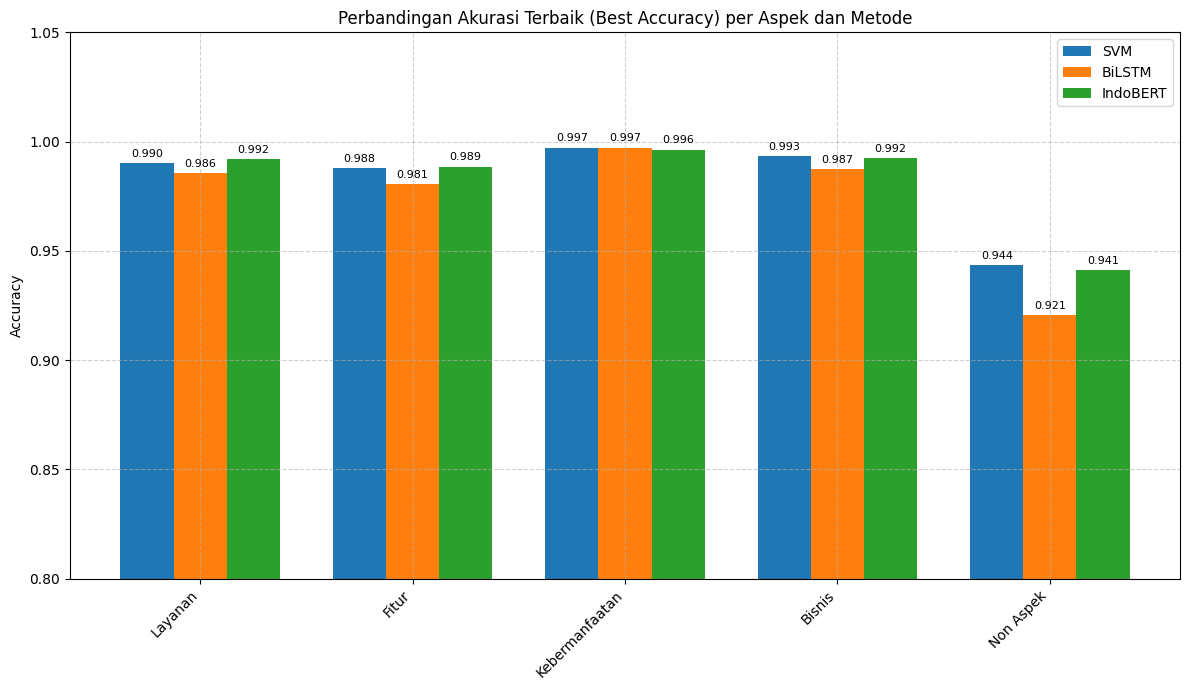

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting from df_best
methods = ['SVM_Best', 'BiLSTM_Best', 'IndoBERT_Best']
labels = df_best['Aspek'].tolist()

x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - width, df_best['SVM_Best'], width, label='SVM')
rects2 = ax.bar(x, df_best['BiLSTM_Best'], width, label='BiLSTM')
rects3 = ax.bar(x + width, df_best['IndoBERT_Best'], width, label='IndoBERT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Perbandingan Akurasi Terbaik (Best Accuracy) per Aspek dan Metode')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0.8, 1.05)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

LABEL_COLS = ["Layanan", "Fitur", "Kebermanfaatan", "Bisnis", "Non Aspek"]

# pastikan tokenizer & MAX_LEN masih ada di memory
assert "tok" in globals(), "Tokenizer (tok) belum ada"
assert "MAX_LEN" in globals(), "MAX_LEN belum ada"

def seq_pad(texts):
    return pad_sequences(tok.texts_to_sequences(texts), maxlen=MAX_LEN)

X_all = seq_pad(df["text_clean"])

for aspek in LABEL_COLS:
    print(f"Predict ulang (tanpa training): {aspek}")

    model_path = f"./plots/bilstm_{aspek}_textonly.h5"
    model = tf.keras.models.load_model(model_path)

    pred_prob = model.predict(X_all, verbose=0)
    df[f"pred_{aspek}"] = (pred_prob >= 0.5).astype(int)

print("\nSemua kolom prediksi berhasil ditambahkan:")
print([c for c in df.columns if c.startswith("pred_")])


Predict ulang (tanpa training): Layanan


Predict ulang (tanpa training): Fitur


Predict ulang (tanpa training): Kebermanfaatan


Predict ulang (tanpa training): Bisnis


Predict ulang (tanpa training): Non Aspek

Semua kolom prediksi berhasil ditambahkan:
['pred_Layanan', 'pred_Fitur', 'pred_Kebermanfaatan', 'pred_Bisnis', 'pred_Non Aspek']


In [ ]:
import numpy as np
from sklearn.metrics import (
    hamming_loss,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

LABEL_COLS = ["Layanan", "Fitur", "Kebermanfaatan", "Bisnis", "Non Aspek"]

# ===============================
# Ground Truth Multi-label
# -1 dan 1 -> dianggap 1
# 0        -> tidak dihitung
# ===============================
y_true_ml = (df[LABEL_COLS].replace(-1, 1) == 1).astype(int).values

# ===============================
# Prediksi Multi-label
# WAJIB sudah ada kolom pred_*
# ===============================
pred_cols = [f"pred_{c}" for c in LABEL_COLS]

missing = [c for c in pred_cols if c not in df.columns]
if missing:
    raise ValueError(f"Kolom prediksi belum ada: {missing}")

y_pred_ml = df[pred_cols].astype(int).values

# ===============================
# METRIK MULTI-LABEL
# ===============================
print("Hamming Loss       :", hamming_loss(y_true_ml, y_pred_ml))
print("Subset Accuracy    :", accuracy_score(y_true_ml, y_pred_ml))

print("\nMicro Precision    :", precision_score(y_true_ml, y_pred_ml, average="micro"))
print("Micro Recall       :", recall_score(y_true_ml, y_pred_ml, average="micro"))
print("Micro F1-score     :", f1_score(y_true_ml, y_pred_ml, average="micro"))

print("\nMacro Precision    :", precision_score(y_true_ml, y_pred_ml, average="macro"))
print("Macro Recall       :", recall_score(y_true_ml, y_pred_ml, average="macro"))
print("Macro F1-score     :", f1_score(y_true_ml, y_pred_ml, average="macro"))


Hamming Loss       : 0.6017985063252553
Subset Accuracy    : 0.015749631661840166

Micro Precision    : 0.23369815845297753
Micro Recall       : 0.618561314997152
Micro F1-score     : 0.3392315244555516

Macro Precision    : 0.240148994675832
Macro Recall       : 0.6423950409372372
Macro F1-score     : 0.3374852087644905


In [ ]:
import pandas as pd

LABEL_COLS = ["Layanan", "Fitur", "Kebermanfaatan", "Bisnis", "Non Aspek"]

rows = []

for _, row in df.iterrows():

    true_labels = [a for a in LABEL_COLS if row[a] in [1, -1]]
    pred_labels = [a for a in LABEL_COLS if row[f"pred_{a}"] == 1]

    if len(true_labels) < 2:
        continue

    true_set = set(true_labels)
    pred_set = set(pred_labels)

    if true_set == pred_set:
        status = "Sesuai"
    elif len(true_set & pred_set) > 0:
        status = "Sebagian Sesuai"
    else:
        status = "Tidak Sesuai"

    rows.append({
        "Contoh Ulasan": row["content"][:150] + "...",
        "Kombinasi Label Asli": ", ".join(true_labels),
        "Kombinasi Prediksi": ", ".join(pred_labels) if pred_labels else "-",
        "Kesesuaian": status
    })

    if len(rows) == 50:
        break

df_multilabel_example = pd.DataFrame(rows)
df_multilabel_example


Contoh Ulasan  \
0   Kenapa appk BUKA LAPAK sekarang susah,,, Saya ...   
1   Aplikasi apaan ini, pembayaran sudah dilakukan...   
2   Limit paylater nay ko gk naik naik padahl udh ...   
3   Toko gw di non aktifkan permanen dan semua pro...   
4   Aplikasinya baik dan bisa dipercaya, sayangnya...   
5   Memang bukalapak the best.. Sangat membantu da...   
6   Apk sangat membantu, mudah dan sangat lengkap....   
7   Respon dan proses transaksi dilapak ini cepat ...   
8   Aplikasi nya bagus, sangat sangat membantu.......   
9   untuk aplikasi sangat mantap, hanya saja pada ...   
10  Belanja di Bukalapak sangat memuaskan, barangn...   
11  bagus aplikasinya.....komplit hampir semua bar...   
12             Sangat memudahkan transaksi belanja...   
13  Bukalapak benar2 ok..saya selalu bayar tepat w...   
14  ok ok pokonya sip sangat membantu buat pencari...   
15  Platform Digital terburuk dari semua sisi,apal...   
16       Bagus pelayanannya, cepat juga sampai nya...   
17  tidak ada fitur chat live admin. dan kedua jug...   
18  Memberikan kemudahan dalam bertransaksi dan co...   
19  Sangat nyaman menggunakan aplikasi ini sungguh...   
20  Sangat baik, respon sangat cepat, trimakasih a...   
21  Bagus sih.. Tpi gk bisa aktifkan payleter bagi...   
22  Bukalapak is very good, bisa melakukan pembaya...   
23  Sekarang JNE truking ga bsa di pake.cuma ada d...   
24  Trimakasih untuk semua ...sangat memuaskan buk...   
25  Terimakasih bukalapak. Kamu aplikasi yang sang...   
26  Sangat buruk pembayaran tidak terverifikasi sa...   
27  Saya beli pulsa 2 kali dengan nilai 20.000 yan...   
28  Sangat² membantu untuk bisa membeli Di *bukala...   
29  mending pikir2 dulu kalian pakek aplikasi ini ...   
30  Sangat membantu utk transaksi jual beli barang...   
31  Bukalapak sangat bagus.. Memudahkan,, Sukses s...   
32  Membantu saya dalam berbelanja dan lapaknya pu...   
33  Untuk pemula seperti saya,bukalapak sangat mem...   
34  Bukalapak benar,,komplit dan sangat,,membatu m...   
35  aplikasi paling buruk,semua voucher ga bisa di...   
36  Apk belanja online yg sangat bagus, memudahkan...   
37  Ga bisa chat penjual Ongkirnya sekarang mahal....   
38  Semoga terus di perbaiki agar lebih mudah dan ...   
39  Bukalapak sekarang bukan seperti dulu konsumen...   
40       Sangat mudah aplikasi ini dan tidak rumit...   
41         Bagusss,,, Akses lancar , fitur lengkap...   
42  Aplikasi berbahaya.uang kita di bekukan tidak ...   
43  Makin kesini makin hancur hancur hancur. Pengi...   
44                        Cepat, mudah dan aman..👍...   
45  Alhamdulillah aplikasinya membantu, mitra prak...   
46              sangat simple dan mudah di gunakan...   
47  Aplikasi simpel dg fitur cukup lengkap, bisa b...   
48  Saya kecewa dgn bukalapak emas pembelian saya ...   
49  Simple mudah . Ada masalah , cpet teratasi. Fa...   

                 Kombinasi Label Asli  \
0           Layanan, Fitur, Non Aspek   
1                    Fitur, Non Aspek   
2                      Layanan, Fitur   
3                   Bisnis, Non Aspek   
4   Layanan, Fitur, Bisnis, Non Aspek   
5   Kebermanfaatan, Bisnis, Non Aspek   
6           Kebermanfaatan, Non Aspek   
7   Layanan, Fitur, Bisnis, Non Aspek   
8           Kebermanfaatan, Non Aspek   
9                    Fitur, Non Aspek   
10                      Fitur, Bisnis   
11                      Fitur, Bisnis   
12            Layanan, Kebermanfaatan   
13                      Fitur, Bisnis   
14             Kebermanfaatan, Bisnis   
15          Layanan, Fitur, Non Aspek   
16                    Layanan, Bisnis   
17             Layanan, Fitur, Bisnis   
18            Layanan, Kebermanfaatan   
19          Kebermanfaatan, Non Aspek   
20                 Layanan, Non Aspek   
21                   Fitur, Non Aspek   
22                     Layanan, Fitur   
23                      Fitur, Bisnis   
24                    Layanan, Bisnis   
25              Fitur, Kebermanfaatan   
26                 Layana

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

labels = ["Layanan", "Fitur", "Kebermanfaatan", "Bisnis", "Non Aspek"]

report_svm = classification_report(
    y_true_ml,
    y_pred_ml,
    target_names=labels,
    output_dict=True
)

df_svm_report = pd.DataFrame(report_svm).T
df_svm_report


precision    recall  f1-score  support
Layanan          0.283643  0.559030  0.376338   5565.0
Fitur            0.287356  0.570175  0.382128   5700.0
Kebermanfaatan   0.250854  0.628072  0.358516   5493.0
Bisnis           0.275639  0.652026  0.387475   5874.0
Non Aspek        0.103252  0.802672  0.182968   1946.0
micro avg        0.233698  0.618561  0.339232  24578.0
macro avg        0.240149  0.642395  0.337485  24578.0
weighted avg     0.260981  0.618561  0.361049  24578.0
samples avg      0.197070  0.647356  0.287607  24578.0

In [ ]:
from sklearn.metrics import hamming_loss

print("Hamming Loss TF-IDF + SVM :", hamming_loss(y_true_ml, y_pred_ml))


Hamming Loss TF-IDF + SVM : 0.6017985063252553
